In [ ]:
import os, json, warnings, glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import firwin, filtfilt, resample_poly

In [ ]:
import psutil
vm = psutil.virtual_memory()
print("Total:", vm.total, "bytes | Available:", vm.available, "bytes")



Total: 13605851136 bytes | Available: 11897782272 bytes


In [ ]:
import sys
print(sys.version)        # full version string
print(sys.version_info)   # major/minor/micro tuple


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
sys.version_info(major=3, minor=12, micro=12, releaselevel='final', serial=0)


In [ ]:
#Loop to find WFDBRecords files
from pathlib import Path

print("CWD:", Path.cwd())
print("Looking for any folder named 'WFDBRecords'...")

candidates = sorted(Path(".").rglob("WFDBRecords"))
for i, p in enumerate(candidates, 1):
    print(f"{i}. {p}")

if not candidates:
    raise FileNotFoundError("Couldn't find any folder named 'WFDBRecords' under the current directory tree. "
                            "Open the notebook in the project root, or paste the absolute path to WFDBRecords.")

# If there are multiple matches, pick the one that sits under a folder named 'results'
# (this matches your screenshot). Otherwise take the first.
chosen = None
for p in candidates:
    if p.parent.name.lower() == "results":
        chosen = p
        break
if chosen is None:
    chosen = candidates[0]

print("\nUsing:", chosen.resolve())
DATA_DIR = chosen  # <-- this is what we'll use below


CWD: /content
Looking for any folder named 'WFDBRecords'...
1. drive/.Encrypted/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords
2. drive/.Encrypted/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords
3. drive/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords
4. drive/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords

Using: /content/drive/.Encrypted/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfiltfilt, resample_poly
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import warnings, os

# ----------------- CONFIG -----------------
DATA_DIR = Path("/content/drive/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords")
OUT_DIR  = Path("./processed_ptbxl_5s_100hz_fast")
OUT_DIR.mkdir(parents=True, exist_ok=True); (OUT_DIR/"npy").mkdir(exist_ok=True)

EXPECTED = ['time','I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
TARGET_FS = 100
BAND = (0.05, 47.0)   # Hz
SEG_SEC = 5
MAX_WORKERS = max(1, mp.cpu_count() - 1)  # leave 1 core free
# ------------------------------------------

def infer_fs(t):
    dt = float(np.median(np.diff(t)))
    if dt <= 0 or not np.isfinite(dt):
        raise ValueError("Bad time axis")
    return int(round(1.0/dt)), dt

def center_crop_samples(n, want):
    if n <= want: return 0, n
    start = (n - want) // 2
    return start, start + want

def preprocess_one(csv_path: Path):
    # 1) load just the needed columns, fast
    try:
        df = pd.read_csv(csv_path, usecols=EXPECTED)
    except Exception as e:
        return {"ok": False, "path": str(csv_path), "err": f"read:{e}"}

    if any(c not in df.columns for c in EXPECTED):
        return {"ok": False, "path": str(csv_path), "err": "missing cols"}

    try:
        t = df['time'].to_numpy()
        fs_src, dt = infer_fs(t)

        # (n,12) matrix
        X = df[EXPECTED[1:]].to_numpy(dtype=float)

        # 2) center crop to 5 s at source fs (reduces work)
        want = SEG_SEC * fs_src
        a, b = center_crop_samples(X.shape[0], want)
        X = X[a:b, :]
        if X.shape[0] < want:
            # pad if record shorter than 5s (rare)
            pad = want - X.shape[0]
            X = np.pad(X, ((0, pad), (0, 0)), mode="constant")

        # 3) band-pass (Butterworth, zero-phase), vectorized across leads
        nyq = fs_src / 2.0
        hi = min(BAND[1], nyq * 0.98)  # keep under Nyquist
        sos = butter(4, [BAND[0]/nyq, hi/nyq], btype="band", output="sos")
        X = sosfiltfilt(sos, X, axis=0)

        # 4) resample to 100 Hz (anti-alias)
        if fs_src != TARGET_FS:
            from math import gcd
            up, down = TARGET_FS, fs_src
            g = gcd(up, down); up//=g; down//=g
            X = resample_poly(X, up, down, axis=0)

        # 5) scale jointly to [-1,1]
        mx, mn = np.nanmax(X), np.nanmin(X)
        X = np.zeros_like(X, dtype=np.float32) if (not np.isfinite(mx) or not np.isfinite(mn) or mx == mn) \
            else (2.0*(X - mn)/(mx - mn) - 1.0).astype(np.float32)

        # 6) ensure exact 5s@100Hz: 500x12
        want_100 = SEG_SEC * TARGET_FS  # 500
        if X.shape[0] >= want_100:
            a, b = center_crop_samples(X.shape[0], want_100)
            X = X[a:b, :]
        else:
            X = np.pad(X, ((0, want_100 - X.shape[0]), (0, 0)), mode="constant")

        # save
        rel = csv_path.relative_to(DATA_DIR).with_suffix("")
        rid = "_".join(rel.parts)
        out_npy = OUT_DIR/"npy"/f"{rid}.npy"
        np.save(out_npy, X)

        meta = {
            "record_id": rid,
            "src_path": str(csv_path),
            "out_path": str(out_npy),
            "fs_src_hz": fs_src,
            "fs_tgt_hz": TARGET_FS,
            "segment_seconds": SEG_SEC,
            "segment_shape": "500x12"
        }
        return {"ok": True, "meta": meta}

    except Exception as e:
        return {"ok": False, "path": str(csv_path), "err": f"proc:{e}"}

# Gather files (recursive)
csv_files = list(DATA_DIR.rglob("*.csv"))
print(f"Found {len(csv_files)} CSVs under {DATA_DIR}")

# Parallel execution
results = []
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futures = {ex.submit(preprocess_one, p): p for p in csv_files}
    for i, fut in enumerate(as_completed(futures), 1):
        res = fut.result()
        results.append(res)
        if i % 200 == 0:
            ok = sum(1 for r in results if r.get("ok"))
            print(f"Progress: {i}/{len(csv_files)} processed, ok={ok}")

# Collate metadata
ok_metas = [r["meta"] for r in results if r.get("ok")]
err_list = [r for r in results if not r.get("ok")]
pd.DataFrame(ok_metas).to_csv(OUT_DIR/"metadata.csv", index=False)
if err_list:
    pd.DataFrame(err_list).to_csv(OUT_DIR/"errors.csv", index=False)

print(f"Done. OK: {len(ok_metas)}, Errors: {len(err_list)}. Output -> {OUT_DIR}")

Found 0 CSVs under /content/drive/MyDrive/HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords
Done. OK: 0, Errors: 0. Output -> processed_ptbxl_5s_100hz_fast


In [ ]:
# ===== Build AF/AFL labels from .hea with progress =====
# Works with your structure:
# HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords/...

from pathlib import Path
import pandas as pd
import re, json
from tqdm import tqdm

# ----------------- CONFIG -----------------
OUT_DIR = Path("processed_ptbxl_5s_100hz_fast")  # your processed folder
META_CSV = OUT_DIR / "metadata.csv"              # created by your preprocessing
LABELS_CSV = OUT_DIR / "labels.csv"
MISSING_CSV = OUT_DIR / "labels_missing.csv"

# SNOMED → AF/AFL mapping
SNOMED_TO_TARGET = {
    "164889003": "AF",   # Atrial fibrillation
    "164890007": "AFL",  # Atrial flutter
}

# Known roots where .hea files may live (use both absolute-ish and relative variants)
KNOWN_ROOTS = [
    Path("HuBERT-ECG/code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords"),
    Path("code/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/results/WFDBRecords"),
    Path("."),  # conservative fallback
]
# ------------------------------------------

assert META_CSV.exists(), f"Missing metadata file: {META_CSV}"

# Load metadata
meta = pd.read_csv(META_CSV)
assert {'record_id','src_path','out_path'}.issubset(meta.columns), "metadata.csv must have record_id, src_path, out_path"

# Auto-derive additional search roots from src_path (parent dirs)
auto_roots = sorted({ Path(p).with_suffix("").parent for p in meta['src_path'].tolist() })
SEARCH_ROOTS = auto_roots + KNOWN_ROOTS

# Deduplicate while preserving order
seen = set()
SEARCH_ROOTS = [p for p in SEARCH_ROOTS if not (p in seen or seen.add(p))]

# Keep only existing
SEARCH_ROOTS = [p for p in SEARCH_ROOTS if p.exists()]
if not SEARCH_ROOTS:
    raise FileNotFoundError("Could not find any existing SEARCH_ROOTS. Check your paths.")

print("Will search .hea under:")
for r in SEARCH_ROOTS:
    print("  -", r.resolve())

# ---- helpers ----
def parse_target_from_text(txt: str) -> str | None:
    """Map free text to AF/AFL; check AFL first to avoid 'AF' inside 'AFL'."""
    if not isinstance(txt, str):
        return None
    up = txt.upper()
    if "FLUTTER" in up or re.search(r"\bAFL\b", up):
        return "AFL"
    if "FIBRILLATION" in up or "AFIB" in up or re.search(r"\bAF\b", up):
        return "AF"
    return None

def parse_target_from_hea(hea_path: Path) -> str | None:
    """Parse #Dx: codes → AF/AFL; fallback to text scan."""
    try:
        txt = hea_path.read_text(errors="ignore")
    except Exception:
        return None

    # 1) Try SNOMED codes on '#Dx:' lines
    # Example: "#Dx: 164889003,59118001,164934002"
    matches = re.findall(r"^\s*#\s*Dx\s*:\s*([0-9,\s]+)\s*$", txt, flags=re.IGNORECASE | re.MULTILINE)
    for m in matches:
        codes = [c for c in re.split(r"[,\s]+", m.strip()) if c.isdigit()]
        for c in codes:
            if c in SNOMED_TO_TARGET:
                return SNOMED_TO_TARGET[c]

    # 2) Fallback: plain-text scan anywhere in header
    return parse_target_from_text(txt)

def guess_hea_path(record_id: str, src_path: str) -> Path | None:
    """
    First try sibling of the src CSV with .hea; else search by stub (e.g., 'JS36735.hea') under SEARCH_ROOTS.
    """
    # Direct sibling: replace .csv with .hea
    src = Path(src_path)
    sib = src.with_suffix(".hea")
    if sib.exists():
        return sib

    # Search by stub name (record filename stem)
    stub = src.stem  # e.g., JS36735
    for root in SEARCH_ROOTS:
        hit = next(root.rglob(f"{stub}.hea"), None)
        if hit and hit.exists():
            return hit
    return None

# ---- main loop with progress ----
rows_ok, rows_missing = [], []
cnt_af = cnt_afl = 0

print("\nScanning headers and building labels.csv ...")
for _, row in tqdm(meta.iterrows(), total=len(meta), ncols=100):
    rid = row['record_id']
    hea = guess_hea_path(rid, row['src_path'])
    tgt = parse_target_from_hea(hea) if hea else None

    if tgt in {"AF","AFL"}:
        rows_ok.append({"record_id": rid, "target": tgt})
        if tgt == "AF":  cnt_af  += 1
        if tgt == "AFL": cnt_afl += 1
    else:
        why = "no .hea found" if hea is None else "no AF/AFL code/text in .hea"
        rows_missing.append({"record_id": rid, "why": why})

# ---- write outputs ----
OUT_DIR.mkdir(parents=True, exist_ok=True)
pd.DataFrame(rows_ok).drop_duplicates("record_id").to_csv(LABELS_CSV, index=False)
pd.DataFrame(rows_missing).to_csv(MISSING_CSV, index=False)

print("\nDone.")
print(f"  Labeled: {len(rows_ok)}  (AF={cnt_af}, AFL={cnt_afl})")
print(f"  Missing: {len(rows_missing)}  -> {MISSING_CSV}")
print(f"  Labels  -> {LABELS_CSV}")

# Quick peek
if rows_ok:
    print("\nHead of labels.csv:")
    print(pd.read_csv(LABELS_CSV).head())
if rows_missing[:5]:
    print("\nExamples of missing (first 5):")
    print(pd.DataFrame(rows_missing).head())


EmptyDataError: No columns to parse from file

In [ ]:
# === Use HuBERT-ECG reproducibility/chapman CSVs to build AF/AFL labels + splits for YOUR preprocessed data ===
from pathlib import Path
import pandas as pd
import numpy as np
import re

# Paths
OUT_DIR = Path("processed_ptbxl_5s_100hz_fast")
META_CSV = OUT_DIR / "metadata.csv"  # from your preprocessing step
CHAPMAN_DIR = Path("reproducibility/chapman")  # adjust if your tree differs

assert META_CSV.exists(), f"Missing {META_CSV}"
assert CHAPMAN_DIR.exists(), f"Missing {CHAPMAN_DIR} (point to HuBERT-ECG/reproducibility/chapman)"

# Helper: load and concatenate HuBERT-ECG splits
def load_chapman_splits(chapman_dir: Path) -> pd.DataFrame:
    # train folds
    trains = sorted(chapman_dir.glob("chapman_train*.csv"))
    vals   = sorted(chapman_dir.glob("chapman_val*.csv"))
    tests  = sorted(chapman_dir.glob("chapman_test.csv"))
    dfs = []
    for p in trains:
        d = pd.read_csv(p)
        d["split_src"] = p.name
        d["split"] = "train"
        dfs.append(d)
    for p in vals:
        d = pd.read_csv(p)
        d["split_src"] = p.name
        d["split"] = "val"
        dfs.append(d)
    for p in tests:
        d = pd.read_csv(p)
        d["split_src"] = p.name
        d["split"] = "test"
        dfs.append(d)
    assert dfs, "No chapman_* CSVs found."
    all_df = pd.concat(dfs, ignore_index=True)
    return all_df

chap = load_chapman_splits(CHAPMAN_DIR)

# Columns vary by repo version; detect AF/AFL columns robustly
lowcols = {c.lower(): c for c in chap.columns}
def find_col(cands):
    for c in cands:
        if c.lower() in lowcols:
            return lowcols[c.lower()]
    return None

AF_COL  = find_col(["AF", "AFIB"])
AFL_COL = find_col(["AFL", "AFLT", "FLUTTER"])

assert AF_COL or AFL_COL, f"Could not find AF/AFL columns in: {chap.columns.tolist()}"

# Extract JS id from "filename" column (e.g., "JS000123.hea.npy" -> "JS000123")
FILENAME_COL = find_col(["filename", "file", "path", "fname"])
assert FILENAME_COL, "No filename column found."
chap["js_id"] = chap[FILENAME_COL].astype(str).str.extract(r"(JS\d+)")

# Keep only AF/AFL positives
def to_target(row):
    af  = row.get(AF_COL, 0)
    afl = row.get(AFL_COL, 0)
    if afl == 1: return "AFL"
    if af  == 1: return "AF"
    return np.nan

chap["target"] = chap.apply(to_target, axis=1)
chap = chap.dropna(subset=["js_id", "target"]).reset_index(drop=True)

# Load your metadata and map your record_id -> js_id (last token)
meta = pd.read_csv(META_CSV)
assert {"record_id","out_path"}.issubset(meta.columns), "metadata.csv must have record_id,out_path"
meta["js_id"] = meta["record_id"].astype(str).str.extract(r"(JS\d+)$")

# Merge labels with your processed files
m = chap.merge(meta[["record_id","js_id","out_path"]], on="js_id", how="inner")

# If multiple files map to same js_id (rare), keep unique by record_id
m = m.drop_duplicates(subset=["record_id"]).reset_index(drop=True)

# Save a simple labels.csv for your pipeline
labels_df = m[["record_id","target"]].sort_values("record_id")
labels_df.to_csv(OUT_DIR/"labels.csv", index=False)
print("Wrote labels.csv:", OUT_DIR/"labels.csv", "rows:", len(labels_df))

# Also save split_* files aligned to YOUR processed npy (train/val/test)
def write_split(name):
    df = m[m["split"]==name][["record_id","target","out_path"]].copy()
    df = df.dropna(subset=["out_path"]).drop_duplicates("record_id")
    outp = OUT_DIR / f"split_{name}.csv"
    df.to_csv(outp, index=False)
    print(f"Wrote {outp} rows={len(df)} by filtering to AF/AFL & available npy")

for s in ["train","val","test"]:
    write_split(s)

# Quick peek
print("\nLabel balance (overall):")
print(labels_df["target"].value_counts())
for s in ["train","val","test"]:
    p = OUT_DIR / f"split_{s}.csv"
    if p.exists():
        d = pd.read_csv(p)
        print(f"{s.upper()} counts:", d["target"].value_counts().to_dict())


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

OUT_DIR = Path("processed_ptbxl_5s_100hz_fast")
META = pd.read_csv(OUT_DIR/"metadata.csv")  # record_id, out_path
META["js_id"] = META["record_id"].astype(str).str.extract(r"(JS\d+)$")

# 1) Load HuBERT-ECG chapman CSVs and extract AF/AFL
CHAP = pd.concat([
    pd.read_csv(p).assign(split=("train" if "train" in p.stem else "val" if "val" in p.stem else "test"))
    for p in sorted(Path("reproducibility/chapman").glob("chapman_*.csv"))
], ignore_index=True)

# columns vary; pick them robustly
low = {c.lower(): c for c in CHAP.columns}
fname = low.get("filename") or low.get("file") or low.get("path")
af    = low.get("af") or low.get("afib")
afl   = low.get("afl") or low.get("aflt") or low.get("flutter")
assert fname and (af or afl), f"Check columns: {CHAP.columns.tolist()}"

CHAP["js_id"] = CHAP[fname].astype(str).str.extract(r"(JS\d+)")
CHAP["target"] = np.where(afl and (CHAP[afl]==1), "AFL",
                   np.where(af and (CHAP[af]==1), "AF", np.nan))
CHAP = CHAP.dropna(subset=["js_id","target"])

# 2) Merge to metadata to get the TRUE out_path
M = CHAP.merge(META[["record_id","js_id","out_path"]], on="js_id", how="inner").drop_duplicates("record_id")

# 3) If any split is tiny after filtering, rebuild stratified splits from M
def save_split(name, df): df[["record_id","target","out_path"]].to_csv(OUT_DIR/f"split_{name}.csv", index=False)

train = M[M["split"]=="train"]; val = M[M["split"]=="val"]; test = M[M["split"]=="test"]

MIN_PER_CLASS = 10
def ok(d):
    c = d["target"].value_counts().to_dict()
    return all(c.get(k,0) >= MIN_PER_CLASS for k in ["AF","AFL"])

if not ok(val) or not ok(test):
    df_all = M[["record_id","target","out_path"]].reset_index(drop=True)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
    idx_tr, idx_te = next(sss1.split(df_all, df_all["target"]))
    rest, test = df_all.iloc[idx_tr], df_all.iloc[idx_te]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    idx_tr, idx_va = next(sss2.split(rest, rest["target"]))
    train, val = rest.iloc[idx_tr], rest.iloc[idx_va]

save_split("train", train)
save_split("val",   val)
save_split("test",  test)

# 4) Verify again
for s in ["train","val","test"]:
    df = pd.read_csv(OUT_DIR/f"split_{s}.csv")
    ok = sum(Path(p).exists() for p in df["out_path"])
    print(s, "final →", ok, "/", len(df), "paths exist")


EmptyDataError: No columns to parse from file

In [ ]:
!pip install loguru
!pip install transformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer


In [ ]:
!python -m pip install --upgrade pip setuptools wheel

# Pin Transformers + Hub (works well on Py3.10)
!python -m pip install "transformers==4.41.2" "huggingface_hub>=0.20,<0.26" safetensors

# Core deps (if you haven’t yet)
!python -m pip install pyyaml numpy pandas scipy scikit-learn tqdm einops

# Torch (CPU example; replace with CUDA wheel if you have a GPU)
!ython -m pip install torch torchaudio --index-url https://download.pytorch.org/whl/cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 38.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.9 MB/s  0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Succes

In [ ]:
!python -m pip install "wandb>=0.15,<0.18"

# If you have an account/token
#!wandb login

# Or disable online logging for this run
#export WANDB_MODE=offline            # (Linux/macOS)
# setx WANDB_MODE offline            # (Windows CMD)


In [ ]:
!python -m pip install neurokit2


In [ ]:
!python -m pip install torchmetrics


In [ ]:
!python -m pip install torcheval

In [ ]:
!nvidia-smi
!python - << 'PY'
import torch; print("torch:", torch.__version__, "cuda_available:", torch.cuda.is_available())



In [ ]:
!python -m pip install --upgrade pip
!python -m pip install "torch==2.3.1" "torchaudio==2.3.1" --index-url https://download.pytorch.org/whl/cu121


In [ ]:
!python -m pip install --user pyyaml torchmetrics neurokit2 "transformers==4.41.2" "huggingface_hub>=0.20,<0.26" safetensors


In [ ]:
import sys, site, sysconfig
print("Python:", sys.executable)
print("site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else sysconfig.get_paths()["purelib"])

# install into THIS interpreter
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pytorch-lightning
# (or) !{sys.executable} -m pip install lightning


In [ ]:
import pytorch_lightning as pl
print("pl:", pl.__version__)


In [ ]:
!OMP_NUM_THREADS=1 MKL_NUM_THREADS=1 \
python code/finetune.py \
  1 \
  reproducibility/chapman/chapman_train0.csv \
  reproducibility/chapman/chapman_val0.csv \
  500 \
  3 \
  16 \
  f1_score \
  --epochs 2 \
  --largeness small \
  --lr 1e-3 \
  --wandb_run_name cpu_smoke_test


python3: can't open file '/content/code/finetune.py': [Errno 2] No such file or directory


In [ ]:
# @title Stage 1: GPU Hubert-ECG
!pip install -q "transformers>=4.44" huggingface_hub "torch>=2.1" torchaudio \pytorch-lightning einops scikit-learn pandas numpy scipy neurokit2


In [ ]:
# ==== RESUMEABLE EMBEDDING + TRAIN (HuBERT-ECG, per-record cache) ====
import os, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve, average_precision_score
import joblib

warnings.filterwarnings("ignore")

# ----- paths (reuse your existing OUT_DIR_ABS / SPLITS if you already defined them) -----
OUT_DIR_ABS = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast").resolve()
SPLITS  = {
    "train": OUT_DIR_ABS / "split_train.csv",
    "val":   OUT_DIR_ABS / "split_val.csv",
    "test":  OUT_DIR_ABS / "split_test.csv",
}
for s,p in SPLITS.items():
    assert p.exists(), f"Missing {p}"

# ----- model config -----
HUBERT_SIZE = "base"  # "small" | "base" | "large"
HF_MODEL_NAME = {
    "small": "Edoardo-BS/hubert-ecg-small",
    "base":  "Edoardo-BS/hubert-ecg-base",
    "large": "Edoardo-BS/hubert-ecg-large",
}[HUBERT_SIZE]

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----- thresholds -----
AF_RECALL_TARGET  = 0.98
AFL_MIN_PRECISION = 0.15
AFL_MIN_RECALL    = 0.60

# ----- per-record embedding cache -----
EMB_ROOT = Path(f"/content/_emb_perrec_hubert_{HUBERT_SIZE}")
(EMB_ROOT/"train").mkdir(parents=True, exist_ok=True)
(EMB_ROOT/"val").mkdir(parents=True, exist_ok=True)
(EMB_ROOT/"test").mkdir(parents=True, exist_ok=True)

# ----- load model (safe to call again) -----
@torch.no_grad()
def load_hubert():
    print(f"Loading HuBERT-ECG: {HF_MODEL_NAME}")
    model = AutoModel.from_pretrained(HF_MODEL_NAME, trust_remote_code=True)
    model.to(device).eval()
    return model

model = load_hubert()

# ----- helpers -----
def load_split(name: str) -> pd.DataFrame:
    df = pd.read_csv(SPLITS[name])
    df["target"] = df["target"].astype("string")  # NaN -> REST
    return df

from scipy.signal import welch

def _bandpower_ratio_simple(sig, fs, band, refband):
    # quick PSD ratios without QRS suppression (fast & good enough for lead pick)
    f, Pxx = welch(sig.astype(np.float32), fs=fs, nperseg=min(256, len(sig)))
    m1 = (f>=band[0]) & (f<=band[1])
    m2 = (f>=refband[0]) & (f<=refband[1])
    bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
    bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
    return bp1 / bp2

def _flutter_score_for_lead(sig, fs=100):
    # sawtooth band (3.5–7 Hz) + harmonic (8–12 Hz)
    fr = _bandpower_ratio_simple(sig, fs, (3.5,7.0), (1.0,20.0))
    h2 = _bandpower_ratio_simple(sig, fs, (8.0,12.0), (1.0,20.0))
    return fr + 0.5*h2

def mono_from_12lead(x_500x12: np.ndarray, policy="lead_II") -> np.ndarray:
    # returns [500] float32
    if x_500x12.ndim != 2 or x_500x12.shape[1] != 12 or x_500x12.shape[0] != 500:
        raise ValueError(f"bad shape {getattr(x_500x12,'shape',None)}")
    if policy == "mean12":
        return x_500x12.mean(axis=1, dtype=np.float32)
    if policy == "best_flutter":
        # evaluate classic AFL-friendly leads and pick the max flutter score
        cand = ['V1','II','V2','III','aVF']
        best_name, best_sig, best_s = 'II', x_500x12[:,1], -1.0
        for name in cand:
            idx = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}[name]
            s = _flutter_score_for_lead(x_500x12[:, idx], fs=100)
            if s > best_s and np.std(x_500x12[:, idx]) > 1e-4:
                best_s, best_name, best_sig = s, name, x_500x12[:, idx]
        return best_sig.astype(np.float32, copy=False)
    # default: Lead II
    return x_500x12[:, 1].astype(np.float32, copy=False)

@torch.no_grad()
def embed_batch(model, batch_1d):
    """
    batch_1d: torch.FloatTensor [B, 500]
    returns: torch.FloatTensor [B, D]
    """
    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
        out = model(batch_1d)
    hs = getattr(out, "last_hidden_state", None)
    if hs is None:
        if torch.is_tensor(out):
            hs = out
        else:
            for v in vars(out).values():
                if torch.is_tensor(v):
                    hs = v; break
    return hs.mean(dim=1) if hs.ndim == 3 else hs  # [B,D]

def resume_embed_split(model, df: pd.DataFrame, split_name: str, batch_size=128, lead_policy="lead_II"):
    """
    Resume-able: writes per-record embeddings to {EMB_ROOT}/{split}/{record_id}.npy
    Only computes missing ones.
    """
    emb_dir = EMB_ROOT / split_name
    done = set(p.stem for p in emb_dir.glob("*.npy"))
    todo_idx = [i for i, rid in enumerate(df["record_id"].astype(str)) if rid not in done]

    print(f"[{split_name}] already have {len(done)} / {len(df)} ; embedding {len(todo_idx)} missing…")
    buf = []; buf_rids = []
    pbar = tqdm(total=len(todo_idx), desc=f"Embed-{split_name}", ncols=100)

    for i in todo_idx:
        rid = str(df.iloc[i]["record_id"])
        try:
            x = np.load(df.iloc[i]["out_path"])   # [500,12]
            mono = mono_from_12lead(x, policy=lead_policy)  # [500]
            buf.append(mono); buf_rids.append(rid)
            if len(buf) >= batch_size:
                xt = torch.from_numpy(np.stack(buf)).to(device)  # [B,500]
                z  = embed_batch(model, xt).detach().cpu().numpy()
                for r, e in zip(buf_rids, z):
                    np.save(emb_dir/f"{r}.npy", e.astype(np.float32))
                buf.clear(); buf_rids.clear()
                pbar.update(batch_size)
        except Exception as e:
            # skip this record, but continue
            pbar.update(1)
            continue

    # flush
    if buf:
        xt = torch.from_numpy(np.stack(buf)).to(device)
        z  = embed_batch(model, xt).detach().cpu().numpy()
        for r, e in zip(buf_rids, z):
            np.save(emb_dir/f"{r}.npy", e.astype(np.float32))
        pbar.update(len(buf))
        buf.clear(); buf_rids.clear()
    pbar.close()

def assemble_X_for_split(df: pd.DataFrame, split_name: str) -> np.ndarray:
    """
    Load per-record embeddings back in CSV order. If any missing, drop those rows to keep alignment.
    """
    emb_dir = EMB_ROOT / split_name
    embs, keep_idx = [], []
    for i, rid in enumerate(df["record_id"].astype(str).tolist()):
        p = emb_dir / f"{rid}.npy"
        if p.exists():
            embs.append(np.load(p))
            keep_idx.append(i)
    if not embs:
        return np.zeros((0,1), dtype=np.float32), df.iloc[:0]
    X = np.stack(embs).astype(np.float32)
    return X, df.iloc[keep_idx].reset_index(drop=True)

def choose_tau_for_recall(y_true, scores, target_recall=0.98):
    thrs = np.unique(scores)[::-1]
    best = 0.5
    for t in thrs:
        rec = recall_score(y_true, (scores >= t).astype(int), zero_division=0)
        if rec >= target_recall:
            best = float(t)
        else:
            break
    return best

def choose_tau_min_precision_with_recall(y_true, scores, min_precision=0.30, min_recall=0.60):
    P, R, T = precision_recall_curve(y_true, scores)
    # 1) meet both if possible: among those, MAXIMIZE recall, then precision
    both = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if (p >= min_precision and r >= min_recall)]
    if both:
        both.sort(key=lambda z: (z[1], z[0]))  # recall then precision
        return float(both[-1][2])
    # 2) if can't meet both, MEET RECALL first: among those, maximize precision
    byR = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if r >= min_recall]
    if byR:
        byR.sort(key=lambda z: (z[0], z[1]))   # precision then recall
        return float(byR[-1][2])
    # 3) last: meet precision and maximize recall (ONLY if recall set is empty)
    byP = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if p >= min_precision]
    if byP:
        byP.sort(key=lambda z: (z[1], z[0]))   # recall then precision
        return float(byP[-1][2])
    # 4) fallback: tightest τ
    return float(T[-1]) if len(T) else 0.5

def train_head(task_name, pos_label, Xtr, dtr, Xva, dva, Xte, dte, out_root: Path):
    ytr = dtr["target"].eq(pos_label).fillna(False).astype(int).to_numpy()
    yva = dva["target"].eq(pos_label).fillna(False).astype(int).to_numpy()
    yte = dte["target"].eq(pos_label).fillna(False).astype(int).to_numpy()

    clf = make_pipeline(
        StandardScaler(with_mean=True),
        LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
    ).fit(Xtr, ytr)

    # context @0.5
    if len(Xva):
        base_pred = clf.predict(Xva)
        print(f"\n[{task_name}] VAL @0.50:")
        print(classification_report(yva, base_pred, target_names=[f"REST(not {pos_label})", pos_label], digits=4))
        print("CM:\n", confusion_matrix(yva, base_pred))
        ap = average_precision_score(yva, clf.predict_proba(Xva)[:,1])
        print(f"VAL PR-AUC: {ap:.4f}")

    # tune τ
    proba_va = clf.predict_proba(Xva)[:,1] if len(Xva) else np.array([])
    if pos_label == "AF":
        tau = choose_tau_for_recall(yva, proba_va, target_recall=AF_RECALL_TARGET)
        tune_note = f"recall≥{AF_RECALL_TARGET:.2f}"
    else:
        tau = choose_tau_min_precision_with_recall(yva, proba_va, min_precision=AFL_MIN_PRECISION, min_recall=AFL_MIN_RECALL)
        tune_note = f"precision≥{AFL_MIN_PRECISION:.2f} & recall≥{AFL_MIN_RECALL:.2f}"

    # report at τ
    for split_name, X, y in [("VAL", Xva, yva), ("TEST", Xte, yte)]:
        if len(X)==0: continue
        pred = (clf.predict_proba(X)[:,1] >= tau).astype(int)
        print(f"\n[{task_name}] {split_name} @τ={tau:.3f} ({tune_note})")
        print(classification_report(y, pred, target_names=[f"REST(not {pos_label})", pos_label], digits=4))
        print("CM:\n", confusion_matrix(y, pred))

    # export positives @τ
    out_dir = out_root / f"stage1_{task_name}"
    out_dir.mkdir(parents=True, exist_ok=True)
    for split_name, X, y, D in [("val", Xva, yva, dva), ("test", Xte, yte, dte)]:
        if len(X)==0: continue
        proba = clf.predict_proba(X)[:,1]
        idx = np.where(proba >= tau)[0]
        pd.DataFrame({"record_id": D.iloc[idx]["record_id"]}).to_csv(out_dir/f"positives_{split_name}.csv", index=False)
        pd.DataFrame({"record_id": D.iloc[idx]["record_id"], "is_true_positive": y[idx].astype(int)}).to_csv(out_dir/f"positives_{split_name}_with_labels.csv", index=False)
        print(f"[{task_name}] {split_name.upper()} positives @τ={tau:.3f}: {len(idx)}")

    joblib.dump(clf, out_dir/f"{task_name}_logreg_head.joblib")
    with open(out_dir/f"{task_name}_meta.json","w") as f:
        json.dump({
            "task": task_name, "pos_label": pos_label,
            "threshold": float(tau), "tuning": tune_note,
            "created_at": time.ctime(), "embedding": f"{HF_MODEL_NAME} last-layer mean-pooled"
        }, f, indent=2)
    return out_dir

# ====== RUN (resume embedding for each split, then assemble & train) ======
dtr = load_split("train"); dva = load_split("val"); dte = load_split("test")

# Resume-only: this computes ONLY missing per-record files
resume_embed_split(model, dtr, "train", batch_size=128, lead_policy="lead_II")
resume_embed_split(model, dva, "val",   batch_size=128, lead_policy="lead_II")
resume_embed_split(model, dte, "test",  batch_size=128, lead_policy="lead_II")

# Assemble matrices in CSV order (dropping rows whose embedding file is missing)
Xtr, dtr_fixed = assemble_X_for_split(dtr, "train")
Xva, dva_fixed = assemble_X_for_split(dva, "val")
Xte, dte_fixed = assemble_X_for_split(dte, "test")
print("Embed sizes ->", "train:", Xtr.shape, "val:", Xva.shape, "test:", Xte.shape)

# Safety
if min(len(Xtr), len(Xva), len(Xte)) == 0:
    raise RuntimeError("Some split has 0 embeddings after resume; check cache and split paths.")

# Train AF & AFL heads
dir_af  = train_head("AFvsREST",  "AF",  Xtr, dtr_fixed, Xva, dva_fixed, Xte, dte_fixed, OUT_DIR_ABS)
dir_afl = train_head("AFLvsREST", "AFL", Xtr, dtr_fixed, Xva, dva_fixed, Xte, dte_fixed, OUT_DIR_ABS)
print("\nDone. Outputs:")
print(" ", dir_af)
print(" ", dir_afl)


Device: cpu
Loading HuBERT-ECG: Edoardo-BS/hubert-ecg-base


config.json: 0.00B [00:00, ?B/s]

hubert_ecg.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Edoardo-BS/hubert-ecg-base:
- hubert_ecg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/373M [00:00<?, ?B/s]

[train] already have 0 / 6146 ; embedding 6146 missing…


Embed-train: 100%|██████████████████████████████████████████████| 6146/6146 [29:46<00:00,  3.44it/s]


[val] already have 0 / 2049 ; embedding 2049 missing…


Embed-val: 100%|████████████████████████████████████████████████| 2049/2049 [09:51<00:00,  3.47it/s]


[test] already have 0 / 2049 ; embedding 2049 missing…


Embed-test: 100%|███████████████████████████████████████████████| 2049/2049 [10:00<00:00,  3.41it/s]


Embed sizes -> train: (6146, 768) val: (2049, 768) test: (2049, 768)

[AFvsREST] VAL @0.50:
              precision    recall  f1-score   support

REST(not AF)     0.9475    0.9055    0.9260      1693
          AF     0.6288    0.7612    0.6887       356

    accuracy                         0.8804      2049
   macro avg     0.7881    0.8334    0.8073      2049
weighted avg     0.8921    0.8804    0.8848      2049

CM:
 [[1533  160]
 [  85  271]]
VAL PR-AUC: 0.7240

[AFvsREST] VAL @τ=0.500 (recall≥0.98)
              precision    recall  f1-score   support

REST(not AF)     0.9475    0.9055    0.9260      1693
          AF     0.6288    0.7612    0.6887       356

    accuracy                         0.8804      2049
   macro avg     0.7881    0.8334    0.8073      2049
weighted avg     0.8921    0.8804    0.8848      2049

CM:
 [[1533  160]
 [  85  271]]

[AFvsREST] TEST @τ=0.500 (recall≥0.98)
              precision    recall  f1-score   support

REST(not AF)     0.9464    0.8960    

In [ ]:
# --- DIAGNOSE + AUTO-FIX MISSING positives_val_with_labels.csv ---

from pathlib import Path
import pandas as pd

# 1) Make sure OUT points to the SAME directory you used in Stage-1
OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast").resolve()
print("Using OUT =", OUT)

def _list_stage1(task):
    d = OUT / f"stage1_{task}"
    print(f"\nListing {d}  (exists={d.exists()}):")
    if d.exists():
        for p in sorted(d.glob("*")):
            print("  -", p.name)

def _ensure_with_labels(task_name, pos_label):
    stage1_dir = OUT / f"stage1_{task_name}"
    pos_val_csv  = stage1_dir / "positives_val.csv"
    pos_val_lbls = stage1_dir / "positives_val_with_labels.csv"

    # Already present?
    if pos_val_lbls.exists():
        print(f"[OK] {pos_val_lbls} already exists.")
        return pos_val_lbls

    # If we have positives_val.csv, build the labeled file now
    if pos_val_csv.exists():
        sv = pd.read_csv(OUT/"split_val.csv").drop_duplicates("record_id").set_index("record_id")
        sv["target"] = sv["target"].astype("string")

        pv = pd.read_csv(pos_val_csv)
        # keep only ids that exist in split
        pv = pv[pv["record_id"].isin(sv.index)].copy()
        pv["is_true_positive"] = pv["record_id"].map(sv["target"].eq(pos_label)).fillna(False).astype(int)
        pv.to_csv(pos_val_lbls, index=False)

        print(f"[BUILT] {pos_val_lbls}  (TP={pv['is_true_positive'].sum()}/{len(pv)})")
        return pos_val_lbls

    # Nothing to build from → show what exists to help you spot the mismatch
    _list_stage1(task_name)
    raise FileNotFoundError(
        f"Missing {pos_val_lbls} and {pos_val_csv}. "
        f"Re-run Stage-1 export for {task_name} or fix OUT."
    )

# 2) Show what’s actually on disk
_list_stage1("AFvsREST")
_list_stage1("AFLvsREST")

# 3) Build/make sure the labeled files exist where Stage-2 expects them
af_lbl  = _ensure_with_labels("AFvsREST",  "AF")
afl_lbl = _ensure_with_labels("AFLvsREST", "AFL")

# 4) Sanity echo
print("\nResolved files:")
print(" AF labels:", af_lbl, "exists?", af_lbl.exists())
print(" AFL labels:", afl_lbl, "exists?", afl_lbl.exists())


Using OUT = /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast

Listing /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFvsREST  (exists=True):
  - .ipynb_checkpoints
  - AFvsREST_logreg_head.joblib
  - AFvsREST_meta.json
  - positives_test.csv
  - positives_test_with_labels.csv
  - positives_val.csv
  - positives_val_with_labels.csv
  - positives_val_with_labels.csv.csv

Listing /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFLvsREST  (exists=True):
  - AFLvsREST_logreg_head.joblib
  - AFLvsREST_meta.json
  - positives_test.csv
  - positives_test_with_labels.csv
  - positives_val.csv
  - positives_val_with_labels.csv
[OK] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFvsREST/positives_val_with_labels.csv already exists.
[OK] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFLvsREST/positives_val_with_labels.csv already exists.

Resolved files:
 AF labels: /content/drive/MyDri

In [ ]:
# --- Pre-flight: unify OUT, fix double extensions, and get label paths ---

from pathlib import Path
import pandas as pd

OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast").resolve()
print("Using OUT =", OUT)

def _fix_double_ext(stage1_dir: Path):
    """Rename ..._with_labels.csv.csv -> ..._with_labels.csv if present."""
    bad = stage1_dir / "positives_val_with_labels.csv.csv"
    good = stage1_dir / "positives_val_with_labels.csv"
    if bad.exists() and not good.exists():
        bad.rename(good)
        print(f"[FIXED] Renamed {bad.name} -> {good.name}")

def _ensure_labeled(task_name: str, pos_label: str) -> Path:
    """Return path to positives_val_with_labels.csv, building it if needed."""
    stage1 = OUT / f"stage1_{task_name}"
    assert stage1.exists(), f"Missing folder: {stage1}"

    # fix common typo
    _fix_double_ext(stage1)

    lbl = stage1 / "positives_val_with_labels.csv"
    raw = stage1 / "positives_val.csv"

    if lbl.exists():
        return lbl

    if raw.exists():
        # build labeled file from split_val.csv
        sv = pd.read_csv(OUT/"split_val.csv").drop_duplicates("record_id").set_index("record_id")
        sv["target"] = sv["target"].astype("string")
        pv = pd.read_csv(raw)
        pv = pv[pv["record_id"].isin(sv.index)].copy()
        pv["is_true_positive"] = pv["record_id"].map(sv["target"].eq(pos_label)).fillna(False).astype(int)
        pv.to_csv(lbl, index=False)
        print(f"[BUILT] {lbl}  (TP={pv['is_true_positive'].sum()}/{len(pv)})")
        return lbl

    # last resort: any file that matches the pattern
    cand = list(stage1.glob("positives_val_with_labels*.csv"))
    if cand:
        print(f"[WARN] Using alternative file {cand[0].name}")
        return cand[0]

    raise FileNotFoundError(
        f"Need {lbl} or {raw}. Re-run Stage-1 for {task_name} or fix OUT."
    )

af_lbl  = _ensure_labeled("AFvsREST",  "AF")
afl_lbl = _ensure_labeled("AFLvsREST", "AFL")

print("\nResolved label files:")
print(" AF :", af_lbl,  "exists?", af_lbl.exists())
print(" AFL:", afl_lbl, "exists?", afl_lbl.exists())


Using OUT = /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast

Resolved label files:
 AF : /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFvsREST/positives_val_with_labels.csv exists? True
 AFL: /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/stage1_AFLvsREST/positives_val_with_labels.csv exists? True


In [ ]:
# @title Stage-2 Validator (τ-only; print CM for AFL)
# ===========================
# - AF: recall-targeted validator (τ-only)
# - AFL: per-lead flutter features, recall-first τ (τ-only) + CM print
# ===========================
from pathlib import Path
import numpy as np, pandas as pd, json, time, warnings
from scipy.signal import butter, sosfiltfilt, welch, find_peaks
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve
import joblib

warnings.filterwarnings("ignore")

OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
FS = 100
LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

# ---------- AFL τ targets ----------
AFL_MIN_PREC = 0.30
AFL_MIN_RECALL = 0.85

# ---------- helpers ----------
def bandpass(sig, fs, lo, hi, order=4):
    ny = fs/2; hi = min(hi, ny*0.98)
    sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
    return sosfiltfilt(sos, sig)

def safe_load_np(path):
    x = np.load(path)  # (T,12)
    if x.ndim!=2 or x.shape[1]!=12:
        raise ValueError(f"bad shape {getattr(x,'shape',None)}")
    return x

def pick_lead_for_rhythm(x):
    for name in ['II','V1','V2']:
        idx = LEADS[name]
        if np.std(x[:,idx]) > 1e-4:
            return x[:,idx]
    return x[:, np.argmax(np.std(x, axis=0))]

def detect_qrs(sig, fs=FS):
    y = bandpass(sig, fs, 5, 20)
    diff = np.diff(y, prepend=y[0])
    sq = diff**2
    win = max(int(0.12*fs), 1)
    integ = np.convolve(sq, np.ones(win)/win, mode='same')
    peaks, _ = find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ, 85))
    return peaks

def rr_features(qrs_idx, fs=FS):
    if len(qrs_idx) < 3:
        return dict(rr_mean=np.nan, rr_std=np.nan, rr_cv=np.nan, rr_rmssd=np.nan, rr_reg=np.nan)
    rr = np.diff(qrs_idx)/fs
    mean = float(np.mean(rr))
    std = float(np.std(rr))
    cv = float(std/(mean+1e-8))
    rmssd = float(np.sqrt(np.mean(np.diff(rr)**2))) if len(rr)>2 else np.nan
    reg = float(1.0/(1.0+cv))
    return dict(rr_mean=mean, rr_std=std, rr_cv=cv, rr_rmssd=rmssd, rr_reg=reg)

def pwave_metrics(sig, qrs_idx, fs=FS):
    if len(qrs_idx) < 2:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    bp = bandpass(sig, fs, 4, 15)
    wins = []
    for q in qrs_idx:
        a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.05*fs))
        if b > a:
            wins.append(bp[a:b])
    if not wins:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    en = np.array([np.mean(w**2) for w in wins])
    p_en = float(np.median(en))
    thr = max(np.percentile(en, 60), 1e-6)
    p_present = float(np.mean(en > thr))
    pband = bandpass(sig, fs, 3, 9)
    p_peaks, _ = find_peaks(pband, distance=int(0.18*fs), prominence=np.percentile(np.abs(pband), 80))
    p_to_qrs = float(len(p_peaks)/(len(qrs_idx)+1e-6))
    return dict(p_en=p_en, p_present=p_present, p_to_qrs=p_to_qrs)

def flutter_bandpower(sig, fs=FS):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    mask_lo = (f>=3) & (f<=8)
    mask_all = (f>=1) & (f<=20)
    bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
    bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_all.any() else 1e-12
    return dict(flutter_ratio = bp_3_8 / bp_1_20)

def extract_features(npy_path):
    x = safe_load_np(npy_path)
    lead = pick_lead_for_rhythm(x)
    qrs = detect_qrs(lead, FS)
    feats = {}
    feats.update(rr_features(qrs, FS))
    feats.update(pwave_metrics(lead, qrs, FS))
    feats.update(flutter_bandpower(lead, FS))
    feats.update({
        "amp_med": float(np.median(lead)),
        "amp_iqr": float(np.percentile(lead,75)-np.percentile(lead,25))
    })
    return feats

# ----- AFL: per-lead flutter + harmonic + combined score + atrial peak -----
def pwave_perbeat_metrics(sig, qrs_idx, fs=FS):
    if len(qrs_idx) < 2:
        return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
    pband = bandpass(sig, fs, 3, 9)
    en, p_perq = [], []
    for q in qrs_idx:
        a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.06*fs))
        if b <= a: continue
        w = pband[a:b]
        en.append(np.mean(w**2))
        peaks, _ = find_peaks(w, distance=int(0.08*fs), prominence=np.percentile(np.abs(w), 80))
        p_perq.append(len(peaks))
    if not en:
        return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
    en = np.array(en)
    p_en_med = float(np.median(en))
    thr = max(np.percentile(en, 60), 1e-6)
    p_present_frac = float(np.mean(en > thr))
    p_per_qrs_med = float(np.median(p_perq)) if len(p_perq) else 0.0
    return dict(p_en_med=p_en_med, p_present_frac=p_present_frac, p_per_qrs_med=p_per_qrs_med)

def bandpower_ratio(sig, fs, band, refband):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    m1 = (f>=band[0]) & (f<=band[1])
    m2 = (f>=refband[0]) & (f<=refband[1])
    bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
    bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
    return bp1 / bp2

def pick_lead_for_qrs(x):
    for name in ['II','V1','V2']:
        idx = LEADS[name]
        if np.std(x[:, idx]) > 1e-4:
            return x[:, idx], name
    return x[:, np.argmax(np.std(x, axis=0))], 'auto'

def extract_features_AFL(npy_path):
    x = safe_load_np(npy_path)
    qrs_lead, _ = pick_lead_for_qrs(x)
    qrs = detect_qrs(qrs_lead, FS)

    feats = {}
    feats.update(rr_features(qrs, FS))  # will be dropped later (de-emphasize) before modeling

    CANDIDATE_LEADS = ['V1','II','V2','III','aVF']
    perlead = []
    for name in CANDIDATE_LEADS:
        sig = x[:, LEADS[name]].astype(float).copy()
        if len(qrs) > 0:
            for q in qrs:
                a = max(0, q - int(0.06*FS)); b = min(len(sig), q + int(0.06*FS))
                sig[a:b] = 0.0
        fratio = bandpower_ratio(sig, FS, (3, 8), (1, 20))
        h812   = bandpower_ratio(sig, FS, (8, 12), (1, 20))
        score  = fratio + 0.5*h812
        perlead.append((name, fratio, h812, score))

    best_name, best_fr, best_h2, best_score = max(perlead, key=lambda z: z[3])
    best_sig = x[:, LEADS[best_name]]
    feats.update(pwave_perbeat_metrics(best_sig, qrs, FS))
    feats.update({
        "flutter_ratio_qrs_supp": float(best_fr),
        "harmonic_8_12": float(best_h2),
        "flutter_score": float(best_score),
        "amp_med": float(np.median(best_sig)),
        "amp_iqr": float(np.percentile(best_sig,75)-np.percentile(best_sig,25)),
    })
    f, Pxx = welch(bandpass(best_sig, FS, 1, 20), fs=FS, nperseg=min(256,len(best_sig)))
    mask = (f>=3.5) & (f<=7.0)
    if mask.any():
        i = np.argmax(Pxx[mask]); f_peak = float(f[mask][i]); pk = float(Pxx[mask][i])
        lo = max(0, np.where(mask)[0][i]-5); hi = min(len(Pxx), np.where(mask)[0][i]+6)
        baseline = 1e-12 + float(np.median(Pxx[lo:hi])); atrial_peak_h = pk / baseline
    else:
        f_peak, atrial_peak_h = 0.0, 0.0
    feats.update({"atrial_peak_h": atrial_peak_h, "atrial_peak_hz": f_peak})
    return feats

# ---------- thresholds ----------
def choose_tau_for_recall(y_true_bin, scores, target_recall=0.99):
    thrs = np.unique(scores)[::-1]
    best = 0.5
    for t in thrs:
        rec = recall_score(y_true_bin, (scores>=t).astype(int), zero_division=0)
        if rec >= target_recall: best = float(t)
        else: break
    return best

def choose_tau_for_precision_and_recall(y_true, scores, min_precision=0.25, min_recall=0.99):
    P, R, T = precision_recall_curve(y_true, scores)
    cands = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if (p >= min_precision and r >= min_recall)]
    if not cands:
        cand_recall = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if r >= min_recall]
        if cand_recall:
            cand_recall.sort(key=lambda z: (z[0], z[1])); return float(cand_recall[-1][2])
        cand_prec = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if p >= min_precision]
        if cand_prec:
            cand_prec.sort(key=lambda z: (z[1], z[0])); return float(cand_prec[-1][2])
        return float(T[-1]) if len(T) else 0.5
    cands.sort(key=lambda z: (2*z[0]*z[1]/(z[0]+z[1]+1e-9), z[1], z[0]))
    return float(cands[-1][2])

def choose_tau_recall_first(y_true, scores, min_precision=0.30, min_recall=0.85):
    P, R, T = precision_recall_curve(y_true, scores)
    both = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if (p >= min_precision and r >= min_recall)]
    if both:
        both.sort(key=lambda z: (z[1], z[0])); return float(both[-1][2])
    byR = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if r >= min_recall]
    if byR:
        byR.sort(key=lambda z: (z[0], z[1])); return float(byR[-1][2])
    byP = [(p, r, t) for p, r, t in zip(P[:-1], R[:-1], T) if p >= min_precision]
    if byP:
        byP.sort(key=lambda z: (z[1], z[0])); return float(byP[-1][2])
    return float(T[-1]) if len(T) else 0.5

def debug_coefficients(pipeline, feat_cols, title="AFL validator"):
    lr = pipeline.named_steps["logisticregression"]; w = lr.coef_.ravel()
    order = np.argsort(-np.abs(w))
    print(f"\n[{title}] top-weighted features:")
    for i in order[:12]:
        print(f"  {feat_cols[i]:28s}  weight={w[i]: .4f}")

# ---------- core ----------
def train_validator(task_name):
    print(f"\n=== Train {task_name} validator ===")
    pos_val = OUT/f"stage1_{task_name}/positives_val_with_labels.csv"
    assert pos_val.exists(), f"Missing {pos_val}. Run Stage-1 first."
    df = pd.read_csv(pos_val)
    print("Label counts (VAL positives set):", df["is_true_positive"].value_counts(dropna=False).to_dict())

    sv = pd.read_csv(OUT/"split_val.csv").set_index("record_id")
    df["out_path"] = df["record_id"].map(sv["out_path"])
    df = df.dropna(subset=["out_path"]).reset_index(drop=True)

    rows = []
    use_afl = (task_name == "AFLvsREST")
    for rid, p, y in zip(df["record_id"], df["out_path"], df["is_true_positive"]):
        try:
            feats = extract_features_AFL(p) if use_afl else extract_features(p)
            feats["record_id"] = str(rid); feats["y"] = int(y)
            rows.append(feats)
        except Exception as e:
            print("Skip (VAL)", rid, ":", e)
    feat = pd.DataFrame(rows).fillna(0.0)
    if feat.empty: raise RuntimeError("No features extracted on VAL positives.")

    # AFL: de-emphasize RR by dropping them from the validator
    if use_afl:
        rr_drop = ["rr_mean","rr_std","rr_cv","rr_rmssd","rr_reg"]
        feat = feat.drop(columns=[c for c in rr_drop if c in feat.columns])

    yv = feat["y"].to_numpy()
    Xv = feat.drop(columns=["record_id","y"]).to_numpy()
    feat_cols = [c for c in feat.columns if c not in ["record_id","y"]]

    clf = make_pipeline(
        StandardScaler(with_mean=True),
        LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear",
                           C=0.7, class_weight={0:1.0, 1:4.0}, random_state=42)
    )
    clf.fit(Xv, yv)
    debug_coefficients(clf, feat_cols, title=task_name)

    pv = clf.predict_proba(Xv)[:,1]
    if use_afl:
        tau = choose_tau_recall_first(yv, pv, min_precision=AFL_MIN_PREC, min_recall=AFL_MIN_RECALL)
    else:
        tau = choose_tau_for_precision_and_recall(yv, pv, min_precision=0.25, min_recall=0.99)

    print("VAL (validator @τ):")
    print(classification_report(yv, (pv>=tau).astype(int), digits=4))
    print("CM:\n", confusion_matrix(yv, (pv>=tau).astype(int)))
    print(f"Chosen τ: {tau:.4f}")

    joblib.dump(clf, OUT/f"stage2_{task_name}_validator.joblib")
    with open(OUT/f"stage2_{task_name}_meta.json","w") as f:
        json.dump({"threshold": float(tau),
                   "features": feat_cols,
                   "strategy": (f"precision≥{AFL_MIN_PREC}, recall≥{AFL_MIN_RECALL}") if use_afl else "recall≥0.99 (AF unchanged)",
                   "created_at": time.ctime()}, f, indent=2)
    return clf, tau, feat_cols

def _load_candidate_labels(task_name, split_name):
    path = OUT/f"stage1_{task_name}/positives_{split_name}_with_labels.csv"
    if not path.exists(): return {}
    df = pd.read_csv(path)
    return dict(zip(df["record_id"].astype(str), df["is_true_positive"].astype(int)))

def apply_validator(task_name, clf, tau, feat_cols, split_name):
    """
    τ-only for both AF and AFL.
    For AFL, also print CM on the Stage-1 candidate set after τ.
    """
    pos = OUT/f"stage1_{task_name}/positives_{split_name}.csv"
    assert pos.exists(), f"Missing {pos}"
    pos_ids = pd.read_csv(pos)
    pos_ids["record_id"] = pos_ids["record_id"].astype(str)

    split = pd.read_csv(OUT/f"split_{split_name}.csv").set_index("record_id")
    split.index = split.index.astype(str)

    rows = []
    use_afl = (task_name == "AFLvsREST")
    for rid in pos_ids["record_id"]:
        if rid not in split.index: continue
        p = split.loc[rid, "out_path"]
        try:
            feats = extract_features_AFL(p) if use_afl else extract_features(p)
            feats["record_id"] = str(rid)
            rows.append(feats)
        except Exception as e:
            print(f"Skip ({task_name} {split_name}) {rid}: {e}")

    out_dir = OUT/f"stage2_{task_name}"
    Path(out_dir).mkdir(exist_ok=True)

    if not rows:
        pd.DataFrame(columns=["record_id"]).to_csv(Path(out_dir)/f"validator_passed_{split_name}.csv", index=False)
        print(f"{task_name} {split_name.upper()}: kept 0/0 after τ.")
        if use_afl:
            print(f"{task_name} {split_name.upper()} CM after τ: empty.")
        return

    F = pd.DataFrame(rows).fillna(0.0)
    X = F.drop(columns=["record_id"]).reindex(columns=feat_cols, fill_value=0).to_numpy()
    prob = clf.predict_proba(X)[:,1]
    keep_idx = np.where(prob >= tau)[0]
    kept_ids = F.iloc[keep_idx]["record_id"].astype(str)

    # save τ-only kept list
    pd.DataFrame({"record_id": kept_ids}).to_csv(Path(out_dir)/f"validator_passed_{split_name}.csv", index=False)
    print(f"{task_name} {split_name.upper()}: kept {len(keep_idx)}/{len(F)} after τ (τ={tau:.3f}).")

    # For AFL, print CM on the candidate set after τ
    if use_afl:
        lab_map = _load_candidate_labels(task_name, split_name)
        cand_ids = F["record_id"].astype(str).tolist()
        kept_set = set(kept_ids.tolist())
        y_true = np.array([lab_map.get(r, 0) for r in cand_ids], dtype=int)
        y_pred = np.array([1 if r in kept_set else 0 for r in cand_ids], dtype=int)
        print(f"{task_name} {split_name.upper()} CM after τ (on candidate set):")
        print(confusion_matrix(y_true, y_pred))
        print(classification_report(y_true, y_pred, digits=4))

# ===== run both tasks =====
clf_af,  tau_af,  cols_af  = train_validator("AFvsREST")
clf_afl, tau_afl, cols_afl = train_validator("AFLvsREST")

apply_validator("AFvsREST",  clf_af,  tau_af,  cols_af,  "val")
apply_validator("AFvsREST",  clf_af,  tau_af,  cols_af,  "test")
apply_validator("AFLvsREST", clf_afl, tau_afl, cols_afl, "val")
apply_validator("AFLvsREST", clf_afl, tau_afl, cols_afl, "test")

print("\nDone. Outputs:")
print(" -", (OUT/'stage2_AFvsREST').as_posix())
print(" -", (OUT/'stage2_AFLvsREST').as_posix())



=== Train AFvsREST validator ===
Label counts (VAL positives set): {1: 271, 0: 160}

[AFvsREST] top-weighted features:
  rr_reg                        weight=-7.9353
  rr_cv                         weight=-7.8628
  rr_rmssd                      weight= 0.5263
  amp_iqr                       weight=-0.3814
  rr_std                        weight= 0.3090
  p_en                          weight=-0.1420
  p_present                     weight=-0.0976
  rr_mean                       weight=-0.0915
  p_to_qrs                      weight= 0.0573
  flutter_ratio                 weight= 0.0342
  amp_med                       weight=-0.0263
VAL (validator @τ):
              precision    recall  f1-score   support

           0     0.9780    0.5563    0.7092       160
           1     0.7912    0.9926    0.8805       271

    accuracy                         0.8306       431
   macro avg     0.8846    0.7744    0.7948       431
weighted avg     0.8605    0.8306    0.8169       431

CM:
 [[ 89  71]


In [ ]:

# === 00_export_predictions (run AFTER Stage-2) ===
from pathlib import Path
import numpy as np, pandas as pd, json, joblib
from scipy.signal import butter, sosfiltfilt, welch, find_peaks

# ---------- config ----------
OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
FS = 100
TASKS = ["AFvsREST", "AFLvsREST"]
SPLITS = ["val", "test"]
RNG = np.random.default_rng(42)

LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

# ---------- helpers (self-contained; no Stage-2 patch needed) ----------
def bandpass(sig, fs, lo, hi, order=4):
    ny = fs/2; hi = min(hi, ny*0.98)
    sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
    return sosfiltfilt(sos, sig)

def safe_load_np(path):
    x = np.load(path)  # (T,12)
    if x.ndim!=2 or x.shape[1]!=12:
        raise ValueError(f"bad shape {getattr(x,'shape',None)}")
    return x

def pick_lead_for_rhythm_with_name(x):
    for name in ['II','V1','V2']:
        idx = LEADS[name]
        if np.std(x[:,idx]) > 1e-4:
            return x[:,idx], name
    j = int(np.argmax(np.std(x, axis=0)))
    name = list(LEADS.keys())[j]
    return x[:, j], name

def detect_qrs(sig, fs=FS):
    y = bandpass(sig, fs, 5, 20)
    diff = np.diff(y, prepend=y[0])
    sq = diff**2
    win = max(int(0.12*fs), 1)
    integ = np.convolve(sq, np.ones(win)/win, mode='same')
    peaks, _ = find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ, 85))
    return peaks

def rr_features(qrs_idx, fs=FS):
    if len(qrs_idx) < 3:
        return dict(rr_mean=np.nan, rr_std=np.nan, rr_cv=np.nan, rr_rmssd=np.nan, rr_reg=np.nan)
    rr = np.diff(qrs_idx)/fs
    mean = float(np.mean(rr))
    std = float(np.std(rr))
    cv = float(std/(mean+1e-8))
    rmssd = float(np.sqrt(np.mean(np.diff(rr)**2))) if len(rr)>2 else np.nan
    reg = float(1.0/(1.0+cv))
    return dict(rr_mean=mean, rr_std=std, rr_cv=cv, rr_rmssd=rmssd, rr_reg=reg)

def pwave_metrics(sig, qrs_idx, fs=FS):
    if len(qrs_idx) < 2:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    bp = bandpass(sig, fs, 4, 15)
    wins = []
    for q in qrs_idx:
        a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.05*fs))
        if b > a: wins.append(bp[a:b])
    if not wins:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    en = np.array([np.mean(w**2) for w in wins])
    p_en = float(np.median(en))
    thr = max(np.percentile(en, 60), 1e-6)
    p_present = float(np.mean(en > thr))
    pband = bandpass(sig, fs, 3, 9)
    p_peaks, _ = find_peaks(pband, distance=int(0.18*fs), prominence=np.percentile(np.abs(pband), 80))
    p_to_qrs = float(len(p_peaks)/(len(qrs_idx)+1e-6))
    return dict(p_en=p_en, p_present=p_present, p_to_qrs=p_to_qrs)

def flutter_bandpower(sig, fs=FS):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    mask_lo = (f>=3) & (f<=8)
    mask_all = (f>=1) & (f<=20)
    bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
    bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_all.any() else 1e-12
    return dict(flutter_ratio = bp_3_8 / bp_1_20)

def bandpower_ratio(sig, fs, band, refband):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    m1 = (f>=band[0]) & (f<=band[1])
    m2 = (f>=refband[0]) & (f<=refband[1])
    bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
    bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
    return bp1 / bp2

def extract_features_AF(npy_path):
    x = safe_load_np(npy_path)
    lead, lead_name = pick_lead_for_rhythm_with_name(x)
    qrs = detect_qrs(lead, FS)
    feats = {}
    feats.update(rr_features(qrs, FS))
    feats.update(pwave_metrics(lead, qrs, FS))
    feats.update(flutter_bandpower(lead, FS))  # carried for completeness
    feats.update({
        "amp_med": float(np.median(lead)),
        "amp_iqr": float(np.percentile(lead,75)-np.percentile(lead,25)),
        "lead_name": lead_name
    })
    return feats

def extract_features_AFL(npy_path):
    x = safe_load_np(npy_path).astype(float, copy=False)
    # find QRS on rhythm lead, suppress around QRS, then evaluate flutter per lead
    qrs_lead, _ = pick_lead_for_rhythm_with_name(x)
    qrs = detect_qrs(qrs_lead, FS)
    feats = {}
    feats.update(rr_features(qrs, FS))  # may be dropped in your model; ok to keep here
    CANDIDATE_LEADS = ['V1','II','V2','III','aVF']
    perlead = []
    for name in CANDIDATE_LEADS:
        sig = x[:, LEADS[name]].copy()
        if len(qrs) > 0:
            for q in qrs:
                a = max(0, q - int(0.06*FS)); b = min(len(sig), q + int(0.06*FS))
                sig[a:b] = 0.0
        fr = bandpower_ratio(sig, FS, (3, 8), (1, 20))
        h2 = bandpower_ratio(sig, FS, (8, 12), (1, 20))
        sc = fr + 0.5*h2
        perlead.append((name, fr, h2, sc))
    best_name, best_fr, best_h2, best_sc = max(perlead, key=lambda z: z[3])
    best_sig = x[:, LEADS[best_name]]
    feats.update({
        "flutter_ratio_qrs_supp": float(best_fr),
        "harmonic_8_12": float(best_h2),
        "flutter_score": float(best_sc),
        "amp_med": float(np.median(best_sig)),
        "amp_iqr": float(np.percentile(best_sig,75)-np.percentile(best_sig,25)),
        "best_lead": best_name
    })
    return feats

def _load_candidate_labels(task_name, split_name):
    path = OUT/f"stage1_{task_name}/positives_{split_name}_with_labels.csv"
    if not path.exists(): return {}
    df = pd.read_csv(path)
    return dict(zip(df["record_id"].astype(str), df["is_true_positive"].astype(int)))

def export_predictions_for_task(task_name):
    save_dir = OUT/f"analysis_exports/{task_name}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    clf = joblib.load(OUT/f"stage2_{task_name}_validator.joblib")
    with open(OUT/f"stage2_{task_name}_meta.json","r") as f:
        meta = json.load(f)
    tau = float(meta["threshold"])
    feat_cols = meta["features"]

    all_rows = []
    for split_name in SPLITS:
        pos_csv = OUT/f"stage1_{task_name}/positives_{split_name}.csv"
        if not pos_csv.exists():
            print(f"[{task_name}] Missing {pos_csv}, skip.")
            continue
        pos_ids = pd.read_csv(pos_csv)
        pos_ids["record_id"] = pos_ids["record_id"].astype(str)

        split = pd.read_csv(OUT/f"split_{split_name}.csv").set_index("record_id")
        split.index = split.index.astype(str)

        lab_map = _load_candidate_labels(task_name, split_name)

        rows = []
        for rid in pos_ids["record_id"]:
            if rid not in split.index:
                continue
            npy_path = split.loc[rid, "out_path"]
            try:
                if task_name == "AFLvsREST":
                    feats = extract_features_AFL(npy_path); lead = feats.get("best_lead","NA")
                else:
                    feats = extract_features_AF(npy_path);  lead = feats.get("lead_name","NA")
                row = {"record_id": str(rid), "split": split_name, "task": task_name, "lead": lead}
                row.update(feats)
                rows.append(row)
            except Exception as e:
                print(f"Skip ({task_name} {split_name}) {rid}: {e}")

        if not rows:
            continue

        F = pd.DataFrame(rows).fillna(0.0)
        X = F.drop(columns=["record_id","split","task","lead"], errors="ignore") \
             .reindex(columns=feat_cols, fill_value=0.0).to_numpy()
        prob = clf.predict_proba(X)[:,1]
        pred = (prob >= tau).astype(int)
        F["score"] = prob
        F["pred_label"] = pred
        F["true_label"] = F["record_id"].map(lab_map).fillna(0).astype(int)
        F.to_csv(Path(save_dir)/f"predictions_{split_name}.csv", index=False)
        all_rows.append(F)

    if not all_rows:
        print(f"[{task_name}] No rows exported."); return

    DF = pd.concat(all_rows, ignore_index=True)
    DF.to_csv(Path(save_dir)/"predictions_ALL.csv", index=False)

    # tag TP/FP among predicted positives
    PP = DF[DF["pred_label"]==1].copy()
    PP["tp_flag"] = (PP["true_label"]==1).astype(int)
    PP["fp_flag"] = (PP["true_label"]==0).astype(int)

    def stratified_sample(df, n_total=20):
        if df.empty: return df
        df = df.copy()
        # quartiles may collapse if few rows ⇒ use duplicates="drop"
        df["quartile"] = pd.qcut(df["score"], q=4, labels=[1,2,3,4], duplicates="drop")
        want = min(n_total, len(df))
        parts = []
        if "quartile" in df:
            per_q = max(1, want // df["quartile"].nunique())
            for _, sub in df.groupby("quartile"):
                parts.append(sub.sample(n=min(per_q, len(sub)), random_state=42))
        S = pd.concat(parts, ignore_index=True) if parts else df.sample(n=want, random_state=42)
        if len(S) < want:
            S = pd.concat([S, df.drop(S.index).sample(n=want-len(S), random_state=42)], ignore_index=True)
        return S

    samp_dir = OUT/"analysis"/"samples"; samp_dir.mkdir(parents=True, exist_ok=True)

    if "AFvsREST" in DF["task"].unique():
        af_pos = PP[PP["task"]=="AFvsREST"]
        af_TP = stratified_sample(af_pos[af_pos["true_label"]==1], n_total=20)
        af_FP = stratified_sample(af_pos[af_pos["true_label"]==0], n_total=20)
        af_TP.to_csv(samp_dir/"AF_TP.csv", index=False)
        af_FP.to_csv(samp_dir/"AF_FP.csv", index=False)

    if "AFLvsREST" in DF["task"].unique():
        afl_pos = PP[PP["task"]=="AFLvsREST"]
        afl_TP = stratified_sample(afl_pos[afl_pos["true_label"]==1], n_total=20)
        afl_FP = stratified_sample(afl_pos[afl_pos["true_label"]==0], n_total=20)
        afl_TP.to_csv(samp_dir/"AFL_TP.csv", index=False)
        afl_FP.to_csv(samp_dir/"AFL_FP.csv", index=False)

    print("✓ Saved:", (OUT/"analysis"/"samples").as_posix())
    print("  - AF_TP.csv, AF_FP.csv, AFL_TP.csv, AFL_FP.csv")
    print("  - Full per-split exports in:", (OUT/"analysis_exports").as_posix())

# run both tasks
for task in TASKS:
    export_predictions_for_task(task)


Skip (AFvsREST val) 08_086_JS07997: [Errno 5] Input/output error: '/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/npy/08_086_JS07997.npy'


/tmp/ipython-input-4191710622.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
/tmp/ipython-input-4191710622.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_all.any() else 1e-12
/tmp/ipython-input-4191710622.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
/tmp/ipython-input-4191710622.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_a

✓ Saved: /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/samples
  - AF_TP.csv, AF_FP.csv, AFL_TP.csv, AFL_FP.csv
  - Full per-split exports in: /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis_exports


/tmp/ipython-input-4191710622.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
/tmp/ipython-input-4191710622.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
/tmp/ipython-input-4191710622.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
/tmp/ipython-input-4191710622.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
/tmp/ipython-input-4191710622.py:217: FutureWarning: The def

✓ Saved: /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/samples
  - AF_TP.csv, AF_FP.csv, AFL_TP.csv, AFL_FP.csv
  - Full per-split exports in: /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis_exports


In [ ]:
!pip -q install neurokit2 biosppy shap scipy scikit-learn matplotlib pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
# === common_config.py (cell) ===
from pathlib import Path
import numpy as np, pandas as pd
from scipy.signal import butter, sosfiltfilt, welch, find_peaks
import matplotlib.pyplot as plt
import warnings, json, joblib, math

warnings.filterwarnings("ignore")

# ---- paths ----
OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
SAMPLES_DIR = OUT/"analysis"/"samples"
FIGS_DIR = OUT/"figs"
AN_DIR = OUT/"analysis"
FS = 100

LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

FIGS_DIR.mkdir(parents=True, exist_ok=True)
(AN_DIR/"outputs").mkdir(parents=True, exist_ok=True)

# ---- basic helpers ----
def safe_load_np(path):
    x = np.load(path)  # (T,12)
    if x.ndim!=2 or x.shape[1]!=12:
        raise ValueError(f"bad shape {getattr(x,'shape',None)} for {path}")
    return x.astype(float, copy=False)

def bandpass(sig, fs, lo, hi, order=4):
    ny = fs/2; hi = min(hi, ny*0.98)
    sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
    return sosfiltfilt(sos, sig)

def pick_lead_with_name(x, pref=('II','V1','V2')):
    for name in pref:
        idx = LEADS[name]
        if np.std(x[:,idx]) > 1e-4:
            return x[:,idx], name
    j = int(np.argmax(np.std(x, axis=0)))
    name = list(LEADS.keys())[j]
    return x[:, j], name

def find_rpeaks_dual(sig, fs=FS):
    """Return: best_r (np.array), aux dict with details from neurokit + pantompkins."""
    import neurokit2 as nk
    # A) NeuroKit detector
    r_nk = np.array([])
    try:
        _, info = nk.ecg_peaks(sig, sampling_rate=fs, method="neurokit")
        r_nk = info.get("ECG_R_Peaks", np.array([]))
    except Exception:
        pass
    # B) Pan-Tompkins (fallback)
    r_pt = np.array([])
    try:
        _, info2 = nk.ecg_peaks(sig, sampling_rate=fs, method="pantompkins1985")
        r_pt = info2.get("ECG_R_Peaks", np.array([]))
    except Exception:
        pass
    # choose the one with more beats
    best = r_nk if len(r_nk) >= len(r_pt) else r_pt
    return np.asarray(best, dtype=int), {"r_nk": r_nk, "r_pt": r_pt}

def rr_metrics(r, fs=FS):
    if len(r) < 3:
        return dict(meanRR=np.nan, sdRR=np.nan, cvRR=np.nan, rmssd=np.nan, reg_score=np.nan,
                    n_rr=len(r)-1, pct_abnRR=np.nan, ectopics_removed=np.nan)
    rr = np.diff(r)/fs
    meanRR = float(np.mean(rr)); sdRR = float(np.std(rr, ddof=1))
    cvRR   = float(sdRR/(meanRR+1e-9))
    d = np.diff(rr); rmssd = float(np.sqrt(np.mean(d**2))) if len(d)>0 else np.nan
    reg = float(1 - (rmssd/(meanRR+1e-9)))  # crude "regularity"
    # abnormal RR flags (<=0.3s or >=2.0s)
    abn = np.logical_or(rr<=0.3, rr>=2.0)
    pct_abnRR = float(100*np.mean(abn))
    return dict(meanRR=meanRR, sdRR=sdRR, cvRR=cvRR, rmssd=rmssd, reg_score=reg,
                n_rr=int(len(rr)), pct_abnRR=pct_abnRR, ectopics_removed=np.nan)

def p_window_proxies(sig, r, fs=FS, pre_ms=200, post_ms=60):
    """Compute P proxies around -200..-60ms of each R."""
    if len(r)<2:
        return dict(p_energy=np.nan, p_presence=np.nan, p_to_qrs=np.nan, p_flatness=np.nan)
    pband = bandpass(sig, fs, 4, 15)
    wins = []
    pre  = int(pre_ms*fs/1000); post = int(post_ms*fs/1000)
    for q in r:
        a = max(0, q-pre); b = max(0, q-post)
        if b>a and b<=len(pband): wins.append(pband[a:b])
    if not wins:
        return dict(p_energy=np.nan, p_presence=np.nan, p_to_qrs=np.nan, p_flatness=np.nan)
    # equalize
    L = min(len(w) for w in wins)
    W = np.vstack([w[:L] for w in wins])
    avg = np.median(W, axis=0)
    # spectral flatness proxy = var(avg) (simple, robust)
    p_flat = float(np.var(avg))
    # energy
    p_energy = float(np.median(np.mean(W**2, axis=1)))
    # presence ratio
    peaks = np.max(np.abs(W), axis=1)
    thr = np.percentile(peaks, 60)
    p_presence = float(np.mean(peaks > thr))
    # P:QRS ratio (use segmentwise QRS proxy from raw)
    qrs_pk = np.percentile(np.abs(sig), 99) + 1e-9
    p_to_qrs = float(np.median(peaks)/qrs_pk)
    return dict(p_energy=p_energy, p_presence=p_presence, p_to_qrs=p_to_qrs, p_flatness=p_flat)

def psd_features(sig, fs=FS):
    """3–8 Hz ratio, and ridge prominence ~4–5 Hz."""
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(512, len(sig)))
    band = (f>=3)&(f<=8); total = (f>=1)&(f<=20)
    bandpow = float(np.trapz(Pxx[band], f[band])) if np.any(band) else 0.0
    totpow  = float(np.trapz(Pxx[total], f[total])) if np.any(total) else 1e-12
    ratio   = bandpow/totpow
    ridge = (f>=4)&(f<=5.5)
    peak = float(np.max(Pxx[ridge])) if np.any(ridge) else 0.0
    # local baseline around peak:
    if np.any(ridge):
        i = np.argmax(Pxx[ridge]); idx = np.where(ridge)[0][i]
        lo, hi = max(0, idx-5), min(len(Pxx), idx+6)
        baseline = float(np.median(Pxx[lo:hi])) + 1e-12
        prom = peak/baseline
        fpk = float(f[idx])
    else:
        prom, fpk = 0.0, 0.0
    return dict(flutter_ratio=ratio, ridge_4_5=prom, ridge_hz=fpk)

def quality_metrics(sig, fs=FS):
    f, Pxx = welch(sig, fs=fs, nperseg=min(512, len(sig)))
    base = (f>=0.2)&(f<=0.5); mid=(f>=5)&(f<=15)
    basepow = float(np.trapz(Pxx[base], f[base])) if np.any(base) else 0.0
    midpow  = float(np.trapz(Pxx[mid], f[mid])) if np.any(mid) else 1e-12
    baseline_wander = basepow/midpow
    snr_proxy = float(np.var(sig)/(np.var(np.diff(sig))+1e-12))
    sat = float(np.mean(np.isclose(sig, sig.max(), atol=1e-7) | np.isclose(sig, sig.min(), atol=1e-7)))
    return dict(baseline_wander=baseline_wander, snr_proxy=snr_proxy, pct_saturation=sat)

def load_split():
    sv = pd.read_csv(OUT/"split_val.csv").set_index("record_id"); sv.index = sv.index.astype(str)
    st = pd.read_csv(OUT/"split_test.csv").set_index("record_id"); st.index = st.index.astype(str)
    return {"val": sv, "test": st}

def locate_npy(record_id, split_maps):
    for s, df in split_maps.items():
        if str(record_id) in df.index:
            return s, df.loc[str(record_id), "out_path"]
    return None, None


In [ ]:
# === 01_recompute_features.py (cell) ===
split_maps = load_split()

def recompute_row(row, task):
    rid = str(row["record_id"])
    _, npy_path = locate_npy(rid, split_maps)
    if npy_path is None:
        return None
    x = safe_load_np(npy_path)
    # Lead choice: rhythm lead for AF features; V1/II/V2 tested for AFL flutter
    lead_sig, lead_name = pick_lead_with_name(x)
    # R-peaks (dual)
    r, aux = find_rpeaks_dual(lead_sig, FS)
    feats = {}
    feats.update(rr_metrics(r, FS))
    feats.update(quality_metrics(lead_sig, FS))
    # AF focus P-window proxies (still compute for AFL to inspect)
    feats.update(p_window_proxies(lead_sig, r, FS))
    # Flutter PSD: evaluate also on V1 for AFL evidence
    feats.update(psd_features(lead_sig, FS))
    # Best ridge on V1 if available (AFL helpful)
    if "V1" in LEADS:
        sig_v1 = x[:, LEADS["V1"]]
        v1_psd = psd_features(sig_v1, FS)
        feats["flutter_ratio_v1"] = v1_psd["flutter_ratio"]
        feats["ridge_4_5_v1"]     = v1_psd["ridge_4_5"]
        feats["ridge_hz_v1"]      = v1_psd["ridge_hz"]
    feats["lead_used"] = lead_name
    feats["record_id"] = rid
    feats["task"] = task
    feats["split_src"] = row.get("split", "")
    feats["tp_flag"] = int(row.get("true_label", 0)==1 and row.get("pred_label",1)==1)
    feats["fp_flag"] = int(row.get("true_label", 0)==0 and row.get("pred_label",1)==1)
    feats["score"]   = float(row.get("score", np.nan))
    return feats

def recompute_for_task(task):
    # Read the sampled lists
    tp_csv = SAMPLES_DIR/f"{'AF' if task=='AFvsREST' else 'AFL'}_TP.csv"
    fp_csv = SAMPLES_DIR/f"{'AF' if task=='AFvsREST' else 'AFL'}_FP.csv"
    tp = pd.read_csv(tp_csv) if tp_csv.exists() else pd.DataFrame()
    fp = pd.read_csv(fp_csv) if fp_csv.exists() else pd.DataFrame()
    df = pd.concat([tp, fp], ignore_index=True)
    rows = []
    for _, r in df.iterrows():
        try:
            out = recompute_row(r, task)
            if out is not None: rows.append(out)
        except Exception as e:
            print("skip", r.get("record_id"), e)
    F = pd.DataFrame(rows)
    outp = AN_DIR/"outputs"/f"features_recomputed_{task}.csv"
    F.to_csv(outp, index=False)
    print("Saved", outp, F.shape)
    return F

F_AF  = recompute_for_task("AFvsREST")
F_AFL = recompute_for_task("AFLvsREST")


NameError: name 'load_split' is not defined

In [ ]:
# === 01_recompute_features.py (cell) ===
split_maps = load_split()

def recompute_row(row, task):
    rid = str(row["record_id"])
    _, npy_path = locate_npy(rid, split_maps)
    if npy_path is None:
        return None
    x = safe_load_np(npy_path)
    # Lead choice: rhythm lead for AF features; V1/II/V2 tested for AFL flutter
    lead_sig, lead_name = pick_lead_with_name(x)
    # R-peaks (dual)
    r, aux = find_rpeaks_dual(lead_sig, FS)
    feats = {}
    feats.update(rr_metrics(r, FS))
    feats.update(quality_metrics(lead_sig, FS))
    # AF focus P-window proxies (still compute for AFL to inspect)
    feats.update(p_window_proxies(lead_sig, r, FS))
    # Flutter PSD: evaluate also on V1 for AFL evidence
    feats.update(psd_features(lead_sig, FS))
    # Best ridge on V1 if available (AFL helpful)
    if "V1" in LEADS:
        sig_v1 = x[:, LEADS["V1"]]
        v1_psd = psd_features(sig_v1, FS)
        feats["flutter_ratio_v1"] = v1_psd["flutter_ratio"]
        feats["ridge_4_5_v1"]     = v1_psd["ridge_4_5"]
        feats["ridge_hz_v1"]      = v1_psd["ridge_hz"]
    feats["lead_used"] = lead_name
    feats["record_id"] = rid
    feats["task"] = task
    feats["split_src"] = row.get("split", "")
    feats["tp_flag"] = int(row.get("true_label", 0)==1 and row.get("pred_label",1)==1)
    feats["fp_flag"] = int(row.get("true_label", 0)==0 and row.get("pred_label",1)==1)
    feats["score"]   = float(row.get("score", np.nan))
    return feats

def recompute_for_task(task):
    # Read the sampled lists
    tp_csv = SAMPLES_DIR/f"{'AF' if task=='AFvsREST' else 'AFL'}_TP.csv"
    fp_csv = SAMPLES_DIR/f"{'AF' if task=='AFvsREST' else 'AFL'}_FP.csv"
    tp = pd.read_csv(tp_csv) if tp_csv.exists() else pd.DataFrame()
    fp = pd.read_csv(fp_csv) if fp_csv.exists() else pd.DataFrame()
    df = pd.concat([tp, fp], ignore_index=True)
    rows = []
    for _, r in df.iterrows():
        try:
            out = recompute_row(r, task)
            if out is not None: rows.append(out)
        except Exception as e:
            print("skip", r.get("record_id"), e)
    F = pd.DataFrame(rows)
    outp = AN_DIR/"outputs"/f"features_recomputed_{task}.csv"
    F.to_csv(outp, index=False)
    print("Saved", outp, F.shape)
    return F

F_AF  = recompute_for_task("AFvsREST")
F_AFL = recompute_for_task("AFLvsREST")

skip 09_091_JS08483 No module named 'neurokit2'
skip 10_101_JS09514 No module named 'neurokit2'
skip 08_089_JS08278 No module named 'neurokit2'
skip 06_066_JS05870 No module named 'neurokit2'
skip 04_046_JS03792 No module named 'neurokit2'
skip 10_104_JS09817 No module named 'neurokit2'
skip 06_067_JS06007 No module named 'neurokit2'
skip 01_019_JS01006 No module named 'neurokit2'
skip 06_065_JS05826 No module named 'neurokit2'
skip 08_088_JS08236 No module named 'neurokit2'
skip 06_067_JS06053 No module named 'neurokit2'
skip 08_089_JS08245 No module named 'neurokit2'
skip 02_028_JS01966 No module named 'neurokit2'
skip 10_100_JS09435 No module named 'neurokit2'
skip 10_102_JS09609 No module named 'neurokit2'
skip 07_075_JS06799 No module named 'neurokit2'
skip 01_014_JS00483 No module named 'neurokit2'
skip 09_095_JS08898 No module named 'neurokit2'
skip 08_086_JS07939 No module named 'neurokit2'
skip 04_043_JS03464 No module named 'neurokit2'
skip 03_039_JS03112 No module named 'neu

In [ ]:
# === 02_case_panels.py (cell) ===
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=120

def plot_case_panel(record_id, task):
    sname, npy_path = locate_npy(str(record_id), split_maps)
    if npy_path is None:
        print("record not found", record_id); return
    x = safe_load_np(npy_path)
    lead_sig, lead_name = pick_lead_with_name(x)
    r, aux = find_rpeaks_dual(lead_sig, FS)
    rr = np.diff(r)/FS if len(r)>1 else np.array([])
    # P-window overlay data
    pre_ms, post_ms = 200, 60
    pband = bandpass(lead_sig, FS, 4, 15)
    wins = []
    for q in r:
        a = max(0, q-int(pre_ms*FS/1000)); b = max(0, q-int(post_ms*FS/1000))
        if b>a and b<=len(pband): wins.append(pband[a:b])
    avg = np.median(np.vstack([w[:min(map(len,wins))] for w in wins]), axis=0) if len(wins)>1 else None
    # PSD
    f, Pxx = welch(bandpass(lead_sig, FS, 1, 20), fs=FS, nperseg=min(512, len(lead_sig)))

    # ---- plot ----
    Tstrip = min(len(lead_sig)/FS, 12.0)  # up to 12 s
    Nstrip = int(Tstrip*FS)
    t = np.arange(Nstrip)/FS

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot(4,1,1)
    ax1.plot(t, lead_sig[:Nstrip])
    ax1.scatter(r[r<Nstrip]/FS, lead_sig[r[r<Nstrip]], s=12)
    ax1.set_title(f"{task} | {record_id} | Lead {lead_name} | strip+R")
    ax1.set_xlim(0, Tstrip)

    # ax2 = plt.subplot(4,1,2)
    # if rr.size:
    #     ax2.plot(np.arange(len(rr)), rr)
    # ax2.set_title(f"RR tachogram (mean={rr.mean():.3f}s, sd={rr.std(ddof=1) if rr.size else float('nan'):.3f}, CV={rr.std(ddof=1)/rr.mean() if rr.size else float('nan'):.3f})")
    # ax2.set_xlabel("beat"); ax2.set_ylabel("RR (s)")

    N = 2  # show every 2nd label
    ticks = np.arange(0, len(rr), N)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels([f"{i+1}–{i+2}" for i in ticks], rotation=0)

    ax3 = plt.subplot(4,1,3)
    if avg is not None:
        tt = np.arange(len(avg))/FS
        ax3.plot(tt, avg)
        # shade P-window
        ax3.axvspan((pre_ms-200)/1000, (pre_ms-60)/1000, alpha=0.2)
    ax3.set_title("P-window overlay (median beat, 4–15 Hz)")

    ax4 = plt.subplot(4,1,4)
    ax4.plot(f, Pxx)
    ax4.axvspan(3,8, alpha=0.15)
    ax4.axvline(4.5, ls="--")
    ax4.set_xlim(0, 20); ax4.set_xlabel("Hz"); ax4.set_title("PSD (1–20 Hz) with 3–8 Hz band")

    fig.tight_layout()
    subdir = FIGS_DIR/"casepanels"/("AF" if task=="AFvsREST" else "AFL")
    subdir.mkdir(parents=True, exist_ok=True)
    path = subdir/f"{record_id}.png"
    fig.savefig(path, bbox_inches="tight")
    plt.close(fig)
    return path

def batch_panels(F, task, max_n=80):
    ids = list(F["record_id"].unique())[:max_n]
    out = []
    for rid in ids:
        p = plot_case_panel(rid, task)
        if p: out.append(p)
    print("Saved", len(out), "panels to", (FIGS_DIR/"casepanels").as_posix())

batch_panels(F_AF, "AFvsREST")
batch_panels(F_AFL, "AFLvsREST")


KeyError: 'record_id'

In [ ]:
# Show a few saved panels inline
from pathlib import Path
from IPython.display import display, Image

base = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/figs/casepanels")
for sub in ["AF","AFL"]:
    paths = sorted((base/sub).glob("*.png"))[:6]  # first 6
    print(f"\n{sub} panels ({len(paths)} shown):")
    for p in paths:
        display(Image(filename=str(p)))


In [ ]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch, find_peaks
from scipy.stats import mannwhitneyu

# ====== CONFIG: set this to your project folder ======
BASE = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")

SAMPLES_DIR = BASE/"analysis"/"samples"
OUT_DIR     = BASE/"analysis"/"outputs"
FIG_DIR     = BASE/"analysis"/"figs_tp_fp_dists"
FIG_DIR.mkdir(parents=True, exist_ok=True)

FS = 100
LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

# ---------- helpers ----------
def safe_load_np(p):
    x = np.load(p)
    if x.ndim!=2 or x.shape[1]!=12: raise ValueError(f"bad shape {getattr(x,'shape',None)} for {p}")
    return x.astype(float, copy=False)

def bandpass(sig, fs, lo, hi, order=4):
    ny=fs/2; hi=min(hi, ny*0.98); sos=butter(order, [lo/ny, hi/ny], btype='band', output='sos')
    return sosfiltfilt(sos, sig)

def pick_lead_with_name(x, pref=('II','V1','V2')):
    for name in pref:
        i=LEADS[name]
        if np.std(x[:,i])>1e-4: return x[:,i], name
    j=int(np.argmax(np.std(x,axis=0))); name=list(LEADS.keys())[j]
    return x[:,j], name

def find_rpeaks_dual(sig, fs=FS):
    import neurokit2 as nk
    r1=r2=np.array([])
    try: _,info = nk.ecg_peaks(sig, sampling_rate=fs, method="neurokit"); r1=info.get("ECG_R_Peaks", np.array([]))
    except: pass
    try: _,info = nk.ecg_peaks(sig, sampling_rate=fs, method="pantompkins1985"); r2=info.get("ECG_R_Peaks", np.array([]))
    except: pass
    return r1 if len(r1)>=len(r2) else r2

def rr_metrics(r, fs=FS):
    if len(r)<3: return dict(cvRR=np.nan, rmssd=np.nan, reg_score=np.nan)
    rr=np.diff(r)/fs; sd=float(np.std(rr,ddof=1)); mean=float(np.mean(rr))
    cv=sd/(mean+1e-9); d=np.diff(rr); rmssd=float(np.sqrt(np.mean(d**2))) if len(d)>0 else np.nan
    reg=float(1-(rmssd/(mean+1e-9))); return dict(cvRR=cv, rmssd=rmssd, reg_score=reg)

def p_window_proxies(sig, r, fs=FS, pre_ms=200, post_ms=60):
    if len(r)<2: return dict(p_energy=np.nan, p_presence=np.nan, p_to_qrs=np.nan, p_flatness=np.nan)
    pband=bandpass(sig, fs, 4, 15); wins=[]; pre=int(pre_ms*fs/1000); post=int(post_ms*fs/1000)
    for q in r:
        a=max(0, q-pre); b=max(0, q-post)
        if b>a and b<=len(pband): wins.append(pband[a:b])
    if not wins: return dict(p_energy=np.nan, p_presence=np.nan, p_to_qrs=np.nan, p_flatness=np.nan)
    L=min(len(w) for w in wins); W=np.vstack([w[:L] for w in wins]); avg=np.median(W,axis=0)
    p_flat=float(np.var(avg)); p_energy=float(np.median(np.mean(W**2,axis=1)))
    peaks=np.max(np.abs(W),axis=1); thr=np.percentile(peaks,60); p_presence=float(np.mean(peaks>thr))
    qrs_pk=np.percentile(np.abs(sig),99)+1e-9; p_to_qrs=float(np.median(peaks)/qrs_pk)
    return dict(p_energy=p_energy, p_presence=p_presence, p_to_qrs=p_to_qrs, p_flatness=p_flat)

def psd_features(sig, fs=FS):
    f,Pxx=welch(bandpass(sig,fs,1,20), fs=fs, nperseg=min(512,len(sig)))
    m38=(f>=3)&(f<=8); m120=(f>=1)&(f<=20); ratio=float(np.trapz(Pxx[m38],f[m38]))/(float(np.trapz(Pxx[m120],f[m120]))+1e-12)
    ridge=(f>=4)&(f<=5.5)
    if np.any(ridge):
        i=np.argmax(Pxx[ridge]); idx=np.where(ridge)[0][i]
        lo,hi=max(0,idx-5),min(len(Pxx),idx+6); baseline=float(np.median(Pxx[lo:hi]))+1e-12
        prom=float(Pxx[idx]/baseline); fpk=float(f[idx])
    else:
        prom=0.0; fpk=0.0
    return dict(flutter_ratio=ratio, ridge_4_5=prom, ridge_hz=fpk)

def quality_metrics(sig, fs=FS):
    f,Pxx=welch(sig,fs=fs,nperseg=min(512,len(sig)))
    base=(f>=0.2)&(f<=0.5); mid=(f>=5)&(f<=15)
    basepow=float(np.trapz(Pxx[base],f[base])) if np.any(base) else 0.0
    midpow=float(np.trapz(Pxx[mid],f[mid])) if np.any(mid) else 1e-12
    return dict(snr_proxy=float(np.var(sig)/(np.var(np.diff(sig))+1e-12)),
                baseline_wander=basepow/midpow)

def qrs_indices(sig, fs=FS):
    y=bandpass(sig,fs,5,20); diff=np.diff(y,prepend=y[0]); sq=diff**2
    win=max(int(0.12*fs),1); integ=np.convolve(sq, np.ones(win)/win, mode='same')
    peaks,_=find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ,85))
    return peaks

def qrs_suppress(sig, r_idx, fs=FS, ms=60):
    out=sig.copy(); w=int(ms*fs/1000)
    for q in r_idx:
        a=max(0,q-w); b=min(len(out),q+w); out[a:b]=0.0
    return out

def afl_bestlead_features(x):
    # detect QRS on rhythm lead
    rl,_=pick_lead_with_name(x)
    r_idx=qrs_indices(rl, FS)
    best=None; best_row=None
    for name in ['V1','II','V2','III','aVF']:
        sig=x[:,LEADS[name]].astype(float)
        sig_sup=qrs_suppress(sig, r_idx, FS, ms=60)
        f,Pxx=welch(bandpass(sig_sup,FS,1,20), fs=FS, nperseg=min(512,len(sig_sup)))
        m38=(f>=3)&(f<=8); m120=(f>=1)&(f<=20); m812=(f>=8)&(f<=12); m357=(f>=3.5)&(f<=7.0)
        def bp(m): return float(np.trapz(Pxx[m],f[m]))/(float(np.trapz(Pxx[m120],f[m120]))+1e-12) if np.any(m) else 0.0
        fr =  bp(m38)
        h  =  bp(m812)
        score = fr + 0.5*h
        if np.any(m357):
            i=np.argmax(Pxx[m357]); idx=np.where(m357)[0][i]
            lo,hi=max(0,idx-5),min(len(Pxx),idx+6); baseline=float(np.median(Pxx[lo:hi]))+1e-12
            atrial_peak_h=float(Pxx[idx]/baseline); atrial_peak_hz=float(f[idx])
        else:
            atrial_peak_h=0.0; atrial_peak_hz=0.0
        row=dict(best_lead=name, flutter_ratio=fr, harmonic_8_12=h, flutter_score=score,
                 atrial_peak_h=atrial_peak_h, ridge_4_5=atrial_peak_h, ridge_hz=atrial_peak_hz,
                 snr_proxy=float(np.var(sig)/(np.var(np.diff(sig))+1e-12)),
                 baseline_wander=quality_metrics(sig, FS)["baseline_wander"])
        if best is None or score>best: best=score; best_row=row
    return best_row

def load_split_maps():
    sv=pd.read_csv(BASE/"split_val.csv").set_index("record_id"); sv.index=sv.index.astype(str)
    st=pd.read_csv(BASE/"split_test.csv").set_index("record_id"); st.index=st.index.astype(str)
    return {"val": sv, "test": st}

def locate_npy(record_id, split_maps):
    for s,df in split_maps.items():
        if str(record_id) in df.index:
            return s, df.loc[str(record_id), "out_path"]
    return None, None

def cliffs_delta(a,b):
    a=np.asarray(a); b=np.asarray(b)
    a=a[~np.isnan(a)]; b=b[~np.isnan(b)]
    n1,n2=len(a),len(b)
    if n1==0 or n2==0: return np.nan
    a=np.sort(a); b=np.sort(b)
    i=j=0; greater=less=0
    while i<n1 and j<n2:
        if a[i]>b[j]:
            greater+=(n1-i); j+=1
        elif a[i]<b[j]:
            less+=(n2-j); i+=1
        else:
            val=a[i]
            while i<n1 and a[i]==val: i+=1
            while j<n2 and b[j]==val: j+=1
    return (greater-less)/(n1*n2)

def plot_tp_fp_hist(df, feature, title_prefix, out_dir: Path):
    TP = df[df["tp_flag"]==1][feature].dropna()
    FP = df[df["fp_flag"]==1][feature].dropna()
    if len(TP) and len(FP):
        stat,p = mannwhitneyu(TP,FP,alternative="two-sided")
        d = cliffs_delta(TP.values, FP.values)
        tp_med, fp_med = float(np.median(TP)), float(np.median(FP))
    else:
        p=d=tp_med=fp_med=np.nan
    plt.figure(figsize=(6,4))
    plt.hist(TP, bins=24, alpha=0.6, density=True, label="TP")
    plt.hist(FP, bins=24, alpha=0.5, density=True, label="FP")
    plt.title(f"{title_prefix}: {feature}\nmedian(TP)={tp_med:.3g}, median(FP)={fp_med:.3g}; p={p:.3g}, CliffΔ={d:.2f}")
    plt.xlabel(feature); plt.ylabel("Density"); plt.legend()
    out = out_dir/f"{title_prefix.replace(' ','_')}_{feature}.png"
    plt.tight_layout(); plt.savefig(out, bbox_inches="tight"); plt.close()
    return out, {"feature":feature, "tp_median":tp_med, "fp_median":fp_med, "p":p, "cliffs_delta":d, "tp_n":int(len(TP)), "fp_n":int(len(FP))}

# ====== build recomputed tables if missing ======
split_maps = load_split_maps()

af_rec_path  = OUT_DIR/"features_recomputed_AFvsREST.csv"
afl_rec_path = OUT_DIR/"features_recomputed_AFLvsREST.csv"

if not af_rec_path.exists():
    AF_S = pd.concat([pd.read_csv(SAMPLES_DIR/"AF_TP.csv"),
                      pd.read_csv(SAMPLES_DIR/"AF_FP.csv")], ignore_index=True)
    rows=[]
    for _, r in AF_S.iterrows():
        rid=str(r["record_id"])
        _, npy = locate_npy(rid, split_maps)
        if not npy or not Path(npy).exists(): continue
        x = safe_load_np(npy)
        sig, _ = pick_lead_with_name(x)
        rpeaks = find_rpeaks_dual(sig, FS)
        feats = {}
        feats.update(rr_metrics(rpeaks, FS))
        feats.update(p_window_proxies(sig, rpeaks, FS))
        feats.update(psd_features(sig, FS))
        feats.update(quality_metrics(sig, FS))
        feats.update(dict(record_id=rid, tp_flag=int(r.get("true_label",0)==1 and r.get("pred_label",1)==1),
                          fp_flag=int(r.get("true_label",0)==0 and r.get("pred_label",1)==1)))
        rows.append(feats)
    pd.DataFrame(rows).to_csv(af_rec_path, index=False)

if not afl_rec_path.exists():
    AFL_S = pd.concat([pd.read_csv(SAMPLES_DIR/"AFL_TP.csv"),
                       pd.read_csv(SAMPLES_DIR/"AFL_FP.csv")], ignore_index=True)
    rows=[]
    for _, r in AFL_S.iterrows():
        rid=str(r["record_id"])
        _, npy = locate_npy(rid, split_maps)
        if not npy or not Path(npy).exists(): continue
        x = safe_load_np(npy)
        feats = afl_bestlead_features(x)
        feats.update(dict(record_id=rid, tp_flag=int(r.get("true_label",0)==1 and r.get("pred_label",1)==1),
                          fp_flag=int(r.get("true_label",0)==0 and r.get("pred_label",1)==1)))
        rows.append(feats)
    pd.DataFrame(rows).to_csv(afl_rec_path, index=False)

# ====== Load & plot ======
AF  = pd.read_csv(af_rec_path)
AFL = pd.read_csv(afl_rec_path)

af_features  = [c for c in ["cvRR","rmssd","reg_score","p_energy","p_presence","p_to_qrs","p_flatness","snr_proxy","baseline_wander"] if c in AF.columns]
afl_features = [c for c in ["flutter_ratio","ridge_4_5","ridge_hz","harmonic_8_12","snr_proxy","baseline_wander"] if c in AFL.columns]

summaries=[]
af_dir = FIG_DIR/"AF"; afl_dir = FIG_DIR/"AFL"
af_dir.mkdir(parents=True, exist_ok=True); afl_dir.mkdir(parents=True, exist_ok=True)

for feat in af_features:
    pth, summ = plot_tp_fp_hist(AF, feat, "AF TP vs FP", af_dir)
    summaries.append({"task":"AF", **summ, "path": str(pth)})

for feat in afl_features:
    pth, summ = plot_tp_fp_hist(AFL, feat, "AFL TP vs FP", afl_dir)
    summaries.append({"task":"AFL", **summ, "path": str(pth)})

summary_df = pd.DataFrame(summaries)
# from caas_jupyter_tools import display_dataframe_to_user
display(summary_df)

print("Saved AF plots to:", af_dir.as_posix())
print("Saved AFL plots to:", afl_dir.as_posix())

EmptyDataError: No columns to parse from file

In [ ]:
# === TP vs FP summary for AF & AFL ===
from pathlib import Path
import numpy as np, pandas as pd
from scipy.stats import mannwhitneyu

# ---- CONFIG: set to your project root ----
BASE = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
AF_PATH  = BASE/"analysis"/"outputs"/"features_recomputed_AFvsREST.csv"
AFL_PATH = BASE/"analysis"/"outputs"/"features_recomputed_AFLvsREST.csv"

# ---- helpers ----
def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    n1, n2 = len(a), len(b)
    if n1 == 0 or n2 == 0: return np.nan
    a = np.sort(a); b = np.sort(b)
    i = j = 0; greater = less = 0
    while i < n1 and j < n2:
        if a[i] > b[j]:
            greater += (n1 - i); j += 1
        elif a[i] < b[j]:
            less += (n2 - j); i += 1
        else:
            val = a[i]
            while i < n1 and a[i] == val: i += 1
            while j < n2 and b[j] == val: j += 1
    return (greater - less) / (n1 * n2)

def effect_label(delta):
    if np.isnan(delta): return "—"
    ad = abs(delta)
    if ad < 0.147: return "Negligible"
    if ad < 0.33:  return "Small"
    if ad < 0.474: return "Medium"
    return "Large"

def summarize_tp_fp(df, features, title):
    rows = []
    TP = df[df["tp_flag"]==1]
    FP = df[df["fp_flag"]==1]
    for f in features:
        if f not in df.columns:
            continue
        x = TP[f].astype(float).dropna().values
        y = FP[f].astype(float).dropna().values
        tp_med = np.nanmedian(x) if x.size else np.nan
        fp_med = np.nanmedian(y) if y.size else np.nan
        if x.size and y.size:
            _, p = mannwhitneyu(x, y, alternative="two-sided")
            d = cliffs_delta(x, y)
        else:
            p, d = np.nan, np.nan
        rows.append(dict(Task=title, Feature=f,
                         TP_Median=tp_med, FP_Median=fp_med,
                         p_value=p, Cliffs_Delta=d, Effect_Size=effect_label(d),
                         TP_N=x.size, FP_N=y.size))
    return pd.DataFrame(rows)

# ---- load and pick features ----
tables = []
if AF_PATH.exists():
    AF = pd.read_csv(AF_PATH)
    af_feats = [c for c in ["cvRR","rmssd","reg_score","p_presence","p_energy","p_flatness","p_to_qrs",
                            "baseline_wander","snr_proxy"] if c in AF.columns]
    tables.append(summarize_tp_fp(AF, af_feats, "AF"))
else:
    print("Missing:", AF_PATH)

if AFL_PATH.exists():
    AFL = pd.read_csv(AFL_PATH)
    afl_feats = [c for c in ["flutter_ratio","atrial_peak_h","ridge_4_5","ridge_hz","harmonic_8_12",
                             "p_present_frac","p_en_med","p_per_qrs_med",
                             "baseline_wander","snr_proxy"] if c in AFL.columns]
    tables.append(summarize_tp_fp(AFL, afl_feats, "AFL"))
else:
    print("Missing:", AFL_PATH)

if not tables:
    raise SystemExit("No input tables found. Recompute your qualitative features or fix the BASE path.")

summary = pd.concat(tables, ignore_index=True)

# Save CSV and also print a Markdown-ready table per task
OUT = BASE/"analysis"/"outputs"/"tp_fp_feature_summary.csv"
summary.to_csv(OUT, index=False)
print("Saved:", OUT)

# Pretty print per task
for task in summary["Task"].unique():
    sub = summary[summary["Task"]==task].copy()
    sub = sub[["Feature","TP_Median","FP_Median","p_value","Cliffs_Delta","Effect_Size"]]
    # Formatting
    sub["TP_Median"]  = sub["TP_Median"].map(lambda v: f"{v:.4g}" if pd.notna(v) else "—")
    sub["FP_Median"]  = sub["FP_Median"].map(lambda v: f"{v:.4g}" if pd.notna(v) else "—")
    sub["p_value"]    = sub["p_value"].map(lambda v: "<0.001" if (pd.notna(v) and v<1e-3) else (f"{v:.3g}" if pd.notna(v) else "—"))
    sub["Cliffs_Delta"]= sub["Cliffs_Delta"].map(lambda v: f"{v:+.2f}" if pd.notna(v) else "—")
    print(f"\n### {task} — Feature Distribution: TP vs FP")
    print("| Feature | TP Median | FP Median | p-value | Effect Size (Cliff’s Δ) |")
    print("|---|---:|---:|---:|---:|")
    for _, r in sub.iterrows():
        print(f"| **{r['Feature']}** | {r['TP_Median']} | {r['FP_Median']} | {r['p_value']} | {r['Cliffs_Delta']} ({summary.loc[(_==_), 'Effect_Size'] if False else r['Effect_Size']}) |")


EmptyDataError: No columns to parse from file

In [ ]:
# ---- Shim: define AF feature extractor if missing (mirrors your Stage-2 code) ----
try:
    _ = extract_features  # noqa: F821
except NameError:
    import numpy as np
    from scipy.signal import butter, sosfiltfilt, welch, find_peaks

    FS = 100
    LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

    def bandpass(sig, fs, lo, hi, order=4):
        ny = fs/2; hi = min(hi, ny*0.98)
        sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
        return sosfiltfilt(sos, sig)

    def safe_load_np(path):
        x = np.load(path)  # (T,12)
        if x.ndim!=2 or x.shape[1]!=12:
            raise ValueError(f"bad shape {getattr(x,'shape',None)}")
        return x

    def pick_lead_for_rhythm(x):
        for name in ['II','V1','V2']:
            idx = LEADS[name]
            if np.std(x[:,idx]) > 1e-4:
                return x[:,idx]
        return x[:, np.argmax(np.std(x, axis=0))]

    def detect_qrs(sig, fs=FS):
        y = bandpass(sig, fs, 5, 20)
        diff = np.diff(y, prepend=y[0])
        sq = diff**2
        win = max(int(0.12*fs), 1)
        integ = np.convolve(sq, np.ones(win)/win, mode='same')
        peaks, _ = find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ, 85))
        return peaks

    def rr_features(qrs_idx, fs=FS):
        if len(qrs_idx) < 3:
            return dict(rr_mean=np.nan, rr_std=np.nan, rr_cv=np.nan, rr_rmssd=np.nan, rr_reg=np.nan)
        rr = np.diff(qrs_idx)/fs
        mean = float(np.mean(rr))
        std = float(np.std(rr))
        cv = float(std/(mean+1e-8))
        rmssd = float(np.sqrt(np.mean(np.diff(rr)**2))) if len(rr)>2 else np.nan
        reg = float(1.0/(1.0+cv))
        return dict(rr_mean=mean, rr_std=std, rr_cv=cv, rr_rmssd=rmssd, rr_reg=reg)

    def pwave_metrics(sig, qrs_idx, fs=FS):
        if len(qrs_idx) < 2:
            return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
        bp = bandpass(sig, fs, 4, 15)
        wins = []
        for q in qrs_idx:
            a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.05*fs))
            if b > a:
                wins.append(bp[a:b])
        if not wins:
            return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
        en = np.array([np.mean(w**2) for w in wins])
        p_en = float(np.median(en))
        thr = max(np.percentile(en, 60), 1e-6)
        p_present = float(np.mean(en > thr))
        pband = bandpass(sig, fs, 3, 9)
        p_peaks, _ = find_peaks(pband, distance=int(0.18*fs), prominence=np.percentile(np.abs(pband), 80))
        p_to_qrs = float(len(p_peaks)/(len(qrs_idx)+1e-6))
        return dict(p_en=p_en, p_present=p_present, p_to_qrs=p_to_qrs)

    def flutter_bandpower(sig, fs=FS):
        f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
        mask_lo = (f>=3) & (f<=8)
        mask_all = (f>=1) & (f<=20)
        bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
        bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_all.any() else 1e-12
        return dict(flutter_ratio = bp_3_8 / bp_1_20)

    def extract_features(npy_path):
        x = safe_load_np(npy_path)
        lead = pick_lead_for_rhythm(x)
        qrs = detect_qrs(lead, FS)
        feats = {}
        feats.update(rr_features(qrs, FS))
        feats.update(pwave_metrics(lead, qrs, FS))
        feats.update(flutter_bandpower(lead, FS))
        feats.update({
            "amp_med": float(np.median(lead)),
            "amp_iqr": float(np.percentile(lead,75)-np.percentile(lead,25))
        })
        return feats

    print("[Shim] Defined extract_features and its dependencies for AF.")


[Shim] Defined extract_features and its dependencies for AF.


In [ ]:
# @title AF TP vs FP table + FP reduction (Stage-1 -> Stage-2)
# ========= TP vs FP table + FP reduction (Stage-1 -> Stage-2) =========
import json, joblib, numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import mannwhitneyu
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ---- config ----
OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
SPLIT = "val"           # use "val" for the supervisor's request; you can switch to "test"
TASK  = "AFvsREST"      # or "AFLvsREST"

# ---- effect size (Cliff's Δ) helpers ----
def cliffs_delta(tp_vals, fp_vals):
    tp_vals = np.asarray(tp_vals); fp_vals = np.asarray(fp_vals)
    n1, n2 = len(tp_vals), len(fp_vals)
    if n1 == 0 or n2 == 0: return np.nan
    U, _ = mannwhitneyu(tp_vals, fp_vals, alternative='two-sided')
    return (2.0 * U) / (n1 * n2) - 1.0

def cliffs_size_label(delta):
    if pd.isna(delta): return "NA"
    a = abs(delta)
    if a < 0.147: return "Negligible"
    if a < 0.33:  return "Small"
    if a < 0.474: return "Medium"
    return "Large"

# ---- load Stage-1 candidate set + labels for the chosen split ----
pos_wlab = OUT/f"stage1_{TASK}/positives_{SPLIT}_with_labels.csv"
assert pos_wlab.exists(), f"Missing {pos_wlab}. Run Stage-1 first."

df_cand = pd.read_csv(pos_wlab)
df_cand["record_id"] = df_cand["record_id"].astype(str)
df_cand.rename(columns={"is_true_positive":"y"}, inplace=True)

# map to npy paths
split_csv = pd.read_csv(OUT/f"split_{SPLIT}.csv").set_index("record_id")
split_csv.index = split_csv.index.astype(str)
df_cand["out_path"] = df_cand["record_id"].map(split_csv["out_path"])
df_cand = df_cand.dropna(subset=["out_path"]).reset_index(drop=True)

# ---- extract features for ALL candidates (TP+FP) with your Stage-2 extractor ----
rows = []
use_afl = (TASK == "AFLvsREST")
for rid, p, y in zip(df_cand["record_id"], df_cand["out_path"], df_cand["y"]):
    try:
        feats = extract_features_AFL(p) if use_afl else extract_features(p)
        feats["record_id"] = str(rid); feats["y"] = int(y)
        rows.append(feats)
    except Exception as e:
        print("Skip (feature extract)", rid, ":", e)
feat_df = pd.DataFrame(rows).fillna(0.0)
assert not feat_df.empty, "No features extracted."

# If your AFL validator drops RR-features, mirror that for summaries if you want perfect alignment:
# (Optional; leave commented if you want to DISPLAY RR stats too)
# if use_afl:
#     rr_drop = ["rr_mean","rr_std","rr_cv","rr_rmssd","rr_reg"]
#     feat_df = feat_df.drop(columns=[c for c in rr_drop if c in feat_df.columns])

# ---- build TP vs FP summary table ----
TP = feat_df[feat_df["y"]==1]
FP = feat_df[feat_df["y"]==0]

feature_cols = [c for c in feat_df.columns if c not in ["record_id","y"]]
rows_sum = []
for f in feature_cols:
    tp_vals = TP[f].dropna().values
    fp_vals = FP[f].dropna().values
    tp_med  = float(np.median(tp_vals)) if len(tp_vals) else np.nan
    fp_med  = float(np.median(fp_vals)) if len(fp_vals) else np.nan
    if len(tp_vals) and len(fp_vals):
        _, pval = mannwhitneyu(tp_vals, fp_vals, alternative='two-sided')
        delta   = cliffs_delta(tp_vals, fp_vals)
    else:
        pval, delta = np.nan, np.nan
    rows_sum.append({
        "Feature": f,
        "nTP": len(tp_vals),
        "nFP": len(fp_vals),
        "TP Median": tp_med,
        "FP Median": fp_med,
        "p-value": pval,
        "Cliff's Δ": delta,
        "Effect Size": cliffs_size_label(delta),
    })
summary_tbl = pd.DataFrame(rows_sum)
summary_tbl["|Δ|"] = summary_tbl["Cliff's Δ"].abs()
summary_tbl = summary_tbl.sort_values(["|Δ|","p-value"], ascending=[False, True]).drop(columns="|Δ|").reset_index(drop=True)

# Save the table (nice for your slide export)
summary_path = OUT/f"analysis/{TASK.lower()}_{SPLIT}_tp_fp_feature_summary.csv"
Path(summary_path).parent.mkdir(parents=True, exist_ok=True)
summary_tbl.to_csv(summary_path, index=False)
print(f"[Saved] {summary_path}")
print(f"Scope: {TASK} ({SPLIT}); n(TP)={len(TP)}, n(FP)={len(FP)}")

# ---- Stage-1 vs Stage-2 FP counts on this candidate pool ----
# Stage-1 'positives' == these candidates; so FP_before = #FP here.
FP_before = int((df_cand["y"]==0).sum())
TP_before = int((df_cand["y"]==1).sum())

# Load Stage-2 validator + its threshold + feature list (in training order)
clf = joblib.load(OUT/f"stage2_{TASK}_validator.joblib")
meta = json.load(open(OUT/f"stage2_{TASK}_meta.json"))
tau  = float(meta["threshold"])
feat_cols_valid = meta["features"]  # the columns the validator expects (after any drops)

# Align feature matrix to validator columns
X_all = feat_df.drop(columns=["record_id","y"]).reindex(columns=feat_cols_valid, fill_value=0.0).to_numpy()
proba = clf.predict_proba(X_all)[:,1]
kept_mask = (proba >= tau)

# Stage-2 predictions on the candidate pool
y_true = feat_df["y"].to_numpy().astype(int)
FP_after = int(((kept_mask == 1) & (y_true == 0)).sum())
TP_after = int(((kept_mask == 1) & (y_true == 1)).sum())

red_abs = FP_before - FP_after
red_pct = (red_abs / FP_before * 100.0) if FP_before > 0 else np.nan
print(f"FP reduction (Stage-1 -> Stage-2 @τ): {FP_before} -> {FP_after}  (−{red_abs}, {red_pct:.1f}%)")

# ---- Incremental FP reduction curve (add features in |weight| order) ----
# We'll refit LR on the candidate pool with the top-k validator features (k=1..m),
# pick τ with the same strategy used in Stage-2 meta, and measure FP_after_k.

# Figure out weight order from the trained validator
lr = clf.named_steps["logisticregression"]
w  = lr.coef_.ravel()
order = np.argsort(-np.abs(w))        # descending by |weight|
ordered_feats = [feat_cols_valid[i] for i in order]

def choose_tau(y, scores, strategy_meta):
    # Mirror your Stage-2 tuning policies
    from sklearn.metrics import precision_recall_curve, recall_score
    if "recall≥" in strategy_meta and "precision≥" in strategy_meta:
        # AFL style (recall-first with min precision)
        import re
        p = float(re.search(r'precision≥([0-9.]+)', strategy_meta).group(1))
        r = float(re.search(r'recall≥([0-9.]+)', strategy_meta).group(1))
        P, R, T = precision_recall_curve(y, scores)
        both = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if (pp >= p and rr >= r)]
        if both:
            both.sort(key=lambda z: (z[1], z[0])); return float(both[-1][2])
        byR = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if rr >= r]
        if byR:
            byR.sort(key=lambda z: (z[0], z[1])); return float(byR[-1][2])
        byP = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if pp >= p]
        if byP:
            byP.sort(key=lambda z: (z[1], z[0])); return float(byP[-1][2])
        return float(T[-1]) if len(T) else 0.5
    elif "recall≥" in strategy_meta and "precision≥" not in strategy_meta:
        # AF style (very high recall)
        import re
        r = float(re.search(r'recall≥([0-9.]+)', strategy_meta).group(1))
        thrs = np.unique(scores)[::-1]; best = 0.5
        from sklearn.metrics import recall_score
        for t in thrs:
            rec = recall_score(y, (scores >= t).astype(int), zero_division=0)
            if rec >= r: best = float(t)
            else: break
        return best
    else:
        # fallback: maximize F1 in PR space
        P, R, T = precision_recall_curve(y, scores)
        f1 = (2*P*R)/(P+R+1e-12)
        i = int(np.nanargmax(f1[:-1]))
        return float(T[i])

strategy = meta.get("strategy","")
fp_curve = []  # rows: k, used_features, FP_after_k, TP_after_k, tau_k
for k in range(1, len(ordered_feats)+1):
    used = ordered_feats[:k]
    Xk = feat_df[used].to_numpy()
    # Refit a light LR on this candidate pool (same settings as validator)
    clf_k = make_pipeline(
        StandardScaler(with_mean=True),
        LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear",
                           C=0.7, class_weight={0:1.0, 1:4.0}, random_state=42)
    ).fit(Xk, y_true)
    prob_k = clf_k.predict_proba(Xk)[:,1]
    tau_k  = choose_tau(y_true, prob_k, strategy)
    pred_k = (prob_k >= tau_k).astype(int)
    FP_k   = int(((pred_k == 1) & (y_true == 0)).sum())
    TP_k   = int(((pred_k == 1) & (y_true == 1)).sum())
    fp_curve.append({
        "k": k,
        "features_used": ", ".join(used),
        "FP_before": FP_before,
        "FP_after_k": FP_k,
        "TP_after_k": TP_k,
        "FP_reduction_abs": FP_before - FP_k,
        "FP_reduction_pct": (FP_before - FP_k) / FP_before * 100.0 if FP_before>0 else np.nan,
        "tau_k": tau_k
    })

fp_curve_df = pd.DataFrame(fp_curve)
curve_path = OUT/f"analysis/{TASK.lower()}_{SPLIT}_fp_reduction_curve.csv"
fp_curve_df.to_csv(curve_path, index=False)
print(f"[Saved] {curve_path}")

# Quick glance
display(summary_tbl.head(10))
display(fp_curve_df.head(8))


[Saved] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/afvsrest_val_tp_fp_feature_summary.csv
Scope: AFvsREST (val); n(TP)=271, n(FP)=160
FP reduction (Stage-1 -> Stage-2 @τ): 160 -> 71  (−89, 55.6%)
[Saved] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/afvsrest_val_fp_reduction_curve.csv


,Feature,nTP,nFP,TP Median,FP Median,p-value,Cliff's Δ,Effect Size
0,rr_rmssd,271,160,0.208147,0.035705,3.891090e-19,0.515221,Large
1,rr_std,271,160,0.134257,0.021247,1.860190e-17,0.489991,Large
2,rr_cv,271,160,0.190040,0.026525,3.305947e-14,0.437177,Medium
3,rr_reg,271,160,0.840308,0.974160,3.305947e-14,-0.437177,Medium
4,amp_iqr,271,160,0.048368,0.067124,2.290651e-06,-0.272371,Small
5,p_en,271,160,0.000714,0.001204,4.155108e-06,-0.265314,Small
6,p_present,271,160,0.400000,0.400000,3.404181e-01,-0.054013,Negligible
7,rr_mean,271,160,0.690000,0.655000,3.533756e-01,0.053506,Negligible
8,flutter_ratio,271,160,0.391123,0.372843,3.719428e-01,0.051476,Negligible
9,p_to_qrs,271,160,2.000000,2.000000,8.519996e-01,0.010770,Negligible


,k,features_used,FP_before,FP_after_k,TP_after_k,FP_reduction_abs,FP_reduction_pct,tau_k
0,1,rr_reg,160,160,271,0,0.000,0.5
1,2,"rr_reg, rr_cv",160,74,268,86,53.750,0.5
2,3,"rr_reg, rr_cv, rr_rmssd",160,73,267,87,54.375,0.5
3,4,"rr_reg, rr_cv, rr_rmssd, amp_iqr",160,73,268,87,54.375,0.5
4,5,"rr_reg, rr_cv, rr_rmssd, amp_iqr, rr_std",160,73,268,87,54.375,0.5
5,6,"rr_reg, rr_cv, rr_rmssd, amp_iqr, rr_std, p_en",160,71,269,89,55.625,0.5
6,7,"rr_reg, rr_cv, rr_rmssd, amp_iqr, rr_std, p_en...",160,71,268,89,55.625,0.5
7,8,"rr_reg, rr_cv, rr_rmssd, amp_iqr, rr_std, p_en...",160,70,269,90,56.250,0.5


In [ ]:
# @title AFL through features table
# ================= AFL ANALYSIS (AFLvsREST only) =================
# Builds TP vs FP feature table (nTP/nFP, medians, p, Cliff's Δ + size)
# Reports FP reduction Stage-1 -> Stage-2, and incremental FP reduction as features are added.

SPLIT = "val"   # change to "test" if needed

import re, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import mannwhitneyu
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")

# ---------- Ensure AFL extractor is defined (shim copied from your Stage-2) ----------
try:
    _ = extract_features_AFL  # noqa: F821
except NameError:
    import numpy as np
    from scipy.signal import butter, sosfiltfilt, welch, find_peaks

    FS = 100
    LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

    def bandpass(sig, fs, lo, hi, order=4):
        ny = fs/2; hi = min(hi, ny*0.98)
        sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
        return sosfiltfilt(sos, sig)

    def safe_load_np(path):
        x = np.load(path)
        if x.ndim!=2 or x.shape[1]!=12: raise ValueError(f"bad shape {getattr(x,'shape',None)}")
        return x

    def detect_qrs(sig, fs=FS):
        y = bandpass(sig, fs, 5, 20)
        diff = np.diff(y, prepend=y[0]); sq = diff**2
        win = max(int(0.12*fs), 1)
        integ = np.convolve(sq, np.ones(win)/win, mode='same')
        peaks, _ = find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ, 85))
        return peaks

    def pick_lead_for_qrs(x):
        for name in ['II','V1','V2']:
            idx = LEADS[name]
            if np.std(x[:, idx]) > 1e-4:
                return x[:, idx], name
        return x[:, np.argmax(np.std(x, axis=0))], 'auto'

    def rr_features(qrs_idx, fs=FS):
        if len(qrs_idx) < 3:
            return dict(rr_mean=np.nan, rr_std=np.nan, rr_cv=np.nan, rr_rmssd=np.nan, rr_reg=np.nan)
        rr = np.diff(qrs_idx)/fs
        mean = float(np.mean(rr))
        std = float(np.std(rr))
        cv = float(std/(mean+1e-8))
        rmssd = float(np.sqrt(np.mean(np.diff(rr)**2))) if len(rr)>2 else np.nan
        reg = float(1.0/(1.0+cv))
        return dict(rr_mean=mean, rr_std=std, rr_cv=cv, rr_rmssd=rmssd, rr_reg=reg)

    def bandpower_ratio(sig, fs, band, refband):
        f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
        m1 = (f>=band[0]) & (f<=band[1]); m2 = (f>=refband[0]) & (f<=refband[1])
        bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
        bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
        return bp1 / bp2

    def pwave_perbeat_metrics(sig, qrs_idx, fs=FS):
        if len(qrs_idx) < 2:
            return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
        pband = bandpass(sig, fs, 3, 9)
        en, p_perq = [], []
        for q in qrs_idx:
            a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.06*fs))
            if b <= a: continue
            w = pband[a:b]
            en.append(np.mean(w**2))
            peaks, _ = find_peaks(w, distance=int(0.08*fs), prominence=np.percentile(np.abs(w), 80))
            p_perq.append(len(peaks))
        if not en: return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
        en = np.array(en)
        p_en_med = float(np.median(en))
        thr = max(np.percentile(en, 60), 1e-6)
        p_present_frac = float(np.mean(en > thr))
        p_per_qrs_med = float(np.median(p_perq)) if len(p_perq) else 0.0
        return dict(p_en_med=p_en_med, p_present_frac=p_present_frac, p_per_qrs_med=p_per_qrs_med)

    def extract_features_AFL(npy_path):
        x = safe_load_np(npy_path)
        qrs_lead, _ = pick_lead_for_qrs(x); qrs = detect_qrs(qrs_lead, FS)
        feats = {}
        # Keep RR features for DISPLAY (your validator may drop them later)
        feats.update(rr_features(qrs, FS))
        CANDIDATE_LEADS = ['V1','II','V2','III','aVF']
        perlead = []
        for name in CANDIDATE_LEADS:
            sig = x[:, LEADS[name]].astype(float).copy()
            if len(qrs) > 0:
                for q in qrs:
                    a = max(0, q - int(0.06*FS)); b = min(len(sig), q + int(0.06*FS))
                    sig[a:b] = 0.0
            fratio = bandpower_ratio(sig, FS, (3, 8), (1, 20))
            h812   = bandpower_ratio(sig, FS, (8, 12), (1, 20))
            score  = fratio + 0.5*h812
            perlead.append((name, fratio, h812, score))
        best_name, best_fr, best_h2, best_score = max(perlead, key=lambda z: z[3])
        best_sig = x[:, LEADS[best_name]]
        feats.update(pwave_perbeat_metrics(best_sig, qrs, FS))
        feats.update({
            "flutter_ratio_qrs_supp": float(best_fr),
            "harmonic_8_12": float(best_h2),
            "flutter_score": float(best_score),
            "amp_med": float(np.median(best_sig)),
            "amp_iqr": float(np.percentile(best_sig,75)-np.percentile(best_sig,25)),
        })
        f, Pxx = welch(bandpass(best_sig, FS, 1, 20), fs=FS, nperseg=min(256,len(best_sig)))
        mask = (f>=3.5) & (f<=7.0)
        if mask.any():
            i = np.argmax(Pxx[mask]); f_peak = float(f[mask][i]); pk = float(Pxx[mask][i])
            lo = max(0, np.where(mask)[0][i]-5); hi = min(len(Pxx), np.where(mask)[0][i]+6)
            baseline = 1e-12 + float(np.median(Pxx[lo:hi])); atrial_peak_h = pk / baseline
        else:
            f_peak, atrial_peak_h = 0.0, 0.0
        feats.update({"atrial_peak_h": atrial_peak_h, "atrial_peak_hz": f_peak})
        return feats

    print("[Shim] AFL extractor defined.")

# ---------- Stats helpers ----------
def cliffs_delta(tp_vals, fp_vals):
    tp_vals = np.asarray(tp_vals); fp_vals = np.asarray(fp_vals)
    n1, n2 = len(tp_vals), len(fp_vals)
    if n1 == 0 or n2 == 0: return np.nan
    U, _ = mannwhitneyu(tp_vals, fp_vals, alternative='two-sided')
    return (2.0 * U) / (n1 * n2) - 1.0

def cliffs_size_label(delta):
    if pd.isna(delta): return "NA"
    a = abs(delta)
    if a < 0.147: return "Negligible"
    if a < 0.33:  return "Small"
    if a < 0.474: return "Medium"
    return "Large"

# ---------- Load Stage-1 candidates (AFL) with labels ----------
pos_wlab = OUT/"stage1_AFLvsREST/positives_{}_with_labels.csv".format(SPLIT)
assert pos_wlab.exists(), f"Missing {pos_wlab}. Run Stage-1 first."
df_cand = pd.read_csv(pos_wlab)
df_cand["record_id"] = df_cand["record_id"].astype(str)
df_cand.rename(columns={"is_true_positive":"y"}, inplace=True)

split_df = pd.read_csv(OUT/f"split_{SPLIT}.csv").set_index("record_id")
split_df.index = split_df.index.astype(str)
df_cand["out_path"] = df_cand["record_id"].map(split_df["out_path"])
df_cand = df_cand.dropna(subset=["out_path"]).reset_index(drop=True)

# ---------- Extract AFL features for ALL candidates ----------
rows = []
for rid, p, y in zip(df_cand["record_id"], df_cand["out_path"], df_cand["y"]):
    try:
        feats = extract_features_AFL(p)
        feats["record_id"] = str(rid); feats["y"] = int(y)
        rows.append(feats)
    except Exception as e:
        print("Skip (AFL feature extract)", rid, ":", e)
feat_df = pd.DataFrame(rows).fillna(0.0)
assert not feat_df.empty, "No features extracted."

# ---------- TP vs FP feature table ----------
from scipy.stats import mannwhitneyu
TP = feat_df[feat_df["y"]==1]; FP = feat_df[feat_df["y"]==0]
feature_cols = [c for c in feat_df.columns if c not in ["record_id","y"]]

rows_sum = []
for f in feature_cols:
    tp_vals = TP[f].dropna().values
    fp_vals = FP[f].dropna().values
    tp_med  = float(np.median(tp_vals)) if len(tp_vals) else np.nan
    fp_med  = float(np.median(fp_vals)) if len(fp_vals) else np.nan
    if len(tp_vals) and len(fp_vals):
        _, pval = mannwhitneyu(tp_vals, fp_vals, alternative='two-sided')
        delta   = cliffs_delta(tp_vals, fp_vals)
    else:
        pval, delta = np.nan, np.nan
    rows_sum.append({
        "Feature": f, "nTP": len(tp_vals), "nFP": len(fp_vals),
        "TP Median": tp_med, "FP Median": fp_med,
        "p-value": pval, "Cliff's Δ": delta, "Effect Size": cliffs_size_label(delta),
    })
summary_tbl = pd.DataFrame(rows_sum)
summary_tbl["|Δ|"] = summary_tbl["Cliff's Δ"].abs()
summary_tbl = summary_tbl.sort_values(["|Δ|","p-value"], ascending=[False, True]).drop(columns="|Δ|").reset_index(drop=True)

Path(OUT/"analysis").mkdir(parents=True, exist_ok=True)
summary_tbl.to_csv(OUT/f"analysis/afl_{SPLIT}_tp_fp_feature_summary.csv", index=False)
print(f"[Saved] {OUT/'analysis'}/afl_{SPLIT}_tp_fp_feature_summary.csv")
print(f"Scope: AFLvsREST ({SPLIT}); n(TP)={len(TP)}, n(FP)={len(FP)}")

# ---------- FP reduction Stage-1 -> Stage-2 (using YOUR AFL validator) ----------
FP_before = int((df_cand["y"]==0).sum())
TP_before = int((df_cand["y"]==1).sum())

clf = joblib.load(OUT/"stage2_AFLvsREST_validator.joblib")
meta = json.load(open(OUT/"stage2_AFLvsREST_meta.json"))
tau  = float(meta["threshold"])
feat_cols_valid = meta["features"]   # validator's AFL feature set/order

X_all = feat_df.drop(columns=["record_id","y"]).reindex(columns=feat_cols_valid, fill_value=0.0).to_numpy()
proba = clf.predict_proba(X_all)[:,1]
kept_mask = (proba >= tau)
y_true = feat_df["y"].to_numpy().astype(int)

FP_after = int(((kept_mask == 1) & (y_true == 0)).sum())
TP_after = int(((kept_mask == 1) & (y_true == 1)).sum())
red_abs = FP_before - FP_after
red_pct = (red_abs / FP_before * 100.0) if FP_before > 0 else np.nan
print(f"[AFL] FP reduction (Stage-1 -> Stage-2 @τ): {FP_before} -> {FP_after}  (−{red_abs}, {red_pct:.1f}%)")

# ---------- Incremental FP reduction curve (add AFL features by |weight|) ----------
def choose_tau(y, scores, strategy_meta):
    from sklearn.metrics import precision_recall_curve
    mP = re.search(r'precision≥([0-9.]+)', strategy_meta)
    mR = re.search(r'recall≥([0-9.]+)', strategy_meta)
    if mP and mR:
        p_min = float(mP.group(1)); r_min = float(mR.group(1))
        P, R, T = precision_recall_curve(y, scores)
        both = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if (pp >= p_min and rr >= r_min)]
        if both:
            both.sort(key=lambda z: (z[1], z[0])); return float(both[-1][2])
        byR = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if rr >= r_min]
        if byR:
            byR.sort(key=lambda z: (z[0], z[1])); return float(byR[-1][2])
        byP = [(pp, rr, tt) for pp, rr, tt in zip(P[:-1], R[:-1], T) if pp >= p_min]
        if byP:
            byP.sort(key=lambda z: (z[1], z[0])); return float(byP[-1][2])
        return float(T[-1]) if len(T) else 0.5
    # fallback: PR-F1 max
    P, R, T = precision_recall_curve(y, scores)
    f1 = (2*P*R)/(P+R+1e-12)
    i = int(np.nanargmax(f1[:-1])); return float(T[i])

strategy = meta.get("strategy","precision≥0.30, recall≥0.85")
lr = clf.named_steps["logisticregression"]; w = lr.coef_.ravel()
order = np.argsort(-np.abs(w))
ordered_feats = [feat_cols_valid[i] for i in order]

fp_curve = []
for k in range(1, len(ordered_feats)+1):
    used = ordered_feats[:k]
    Xk = feat_df[used].to_numpy()
    clf_k = make_pipeline(
        StandardScaler(with_mean=True),
        LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear",
                           C=0.7, class_weight={0:1.0, 1:4.0}, random_state=42)
    ).fit(Xk, y_true)
    prob_k = clf_k.predict_proba(Xk)[:,1]
    tau_k  = choose_tau(y_true, prob_k, strategy)
    pred_k = (prob_k >= tau_k).astype(int)
    FP_k   = int(((pred_k == 1) & (y_true == 0)).sum())
    TP_k   = int(((pred_k == 1) & (y_true == 1)).sum())
    fp_curve.append({
        "k": k,
        "features_used": ", ".join(used),
        "FP_before": FP_before,
        "FP_after_k": FP_k,
        "TP_after_k": TP_k,
        "FP_reduction_abs": FP_before - FP_k,
        "FP_reduction_pct": (FP_before - FP_k) / FP_before * 100.0 if FP_before>0 else np.nan,
        "tau_k": tau_k
    })

fp_curve_df = pd.DataFrame(fp_curve)
fp_curve_df.to_csv(OUT/f"analysis/afl_{SPLIT}_fp_reduction_curve.csv", index=False)
print(f"[Saved] {OUT/'analysis'}/afl_{SPLIT}_fp_reduction_curve.csv")

try:
    from IPython.display import display
    display(summary_tbl.head(10))
    display(fp_curve_df.head(8))
except Exception:
    pass
# ================= END AFL ANALYSIS =================


[Shim] AFL extractor defined.
[Saved] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/afl_val_tp_fp_feature_summary.csv
Scope: AFLvsREST (val); n(TP)=54, n(FP)=336
[AFL] FP reduction (Stage-1 -> Stage-2 @τ): 336 -> 239  (−97, 28.9%)
[Saved] /content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast/analysis/afl_val_fp_reduction_curve.csv


,Feature,nTP,nFP,TP Median,FP Median,p-value,Cliff's Δ,Effect Size
0,atrial_peak_h,54,336,7.897612,3.245750,0.000043,0.346671,Medium
1,rr_mean,54,336,0.515357,0.619286,0.000268,-0.308973,Small
2,rr_reg,54,336,0.780524,0.867988,0.001221,-0.274140,Small
3,rr_cv,54,336,0.281191,0.152090,0.001221,0.274140,Small
4,rr_std,54,336,0.154784,0.093476,0.011292,0.214782,Small
5,rr_rmssd,54,336,0.212342,0.138434,0.015982,0.204255,Small
6,harmonic_8_12,54,336,0.042617,0.036859,0.044016,0.170745,Small
7,p_present_frac,54,336,0.400000,0.400000,0.129801,-0.126433,Negligible
8,amp_med,54,336,-0.030601,-0.066704,0.149390,0.122244,Negligible
9,amp_iqr,54,336,0.088610,0.072266,0.290047,0.089727,Negligible


,k,features_used,FP_before,FP_after_k,TP_after_k,FP_reduction_abs,FP_reduction_pct,tau_k
0,1,harmonic_8_12,336,331,54,5,1.488095,0.294823
1,2,"harmonic_8_12, amp_med",336,242,46,94,27.976190,0.307902
2,3,"harmonic_8_12, amp_med, p_present_frac",336,244,48,92,27.380952,0.296380
3,4,"harmonic_8_12, amp_med, p_present_frac, flutte...",336,257,49,79,23.511905,0.285758
4,5,"harmonic_8_12, amp_med, p_present_frac, flutte...",336,252,48,84,25.000000,0.290638
5,6,"harmonic_8_12, amp_med, p_present_frac, flutte...",336,245,47,91,27.083333,0.294798
6,7,"harmonic_8_12, amp_med, p_present_frac, flutte...",336,239,46,97,28.869048,0.300057
7,8,"harmonic_8_12, amp_med, p_present_frac, flutte...",336,238,46,98,29.166667,0.301511


Plotting 3 TP and 3 FP examples for AFLvsREST (val)


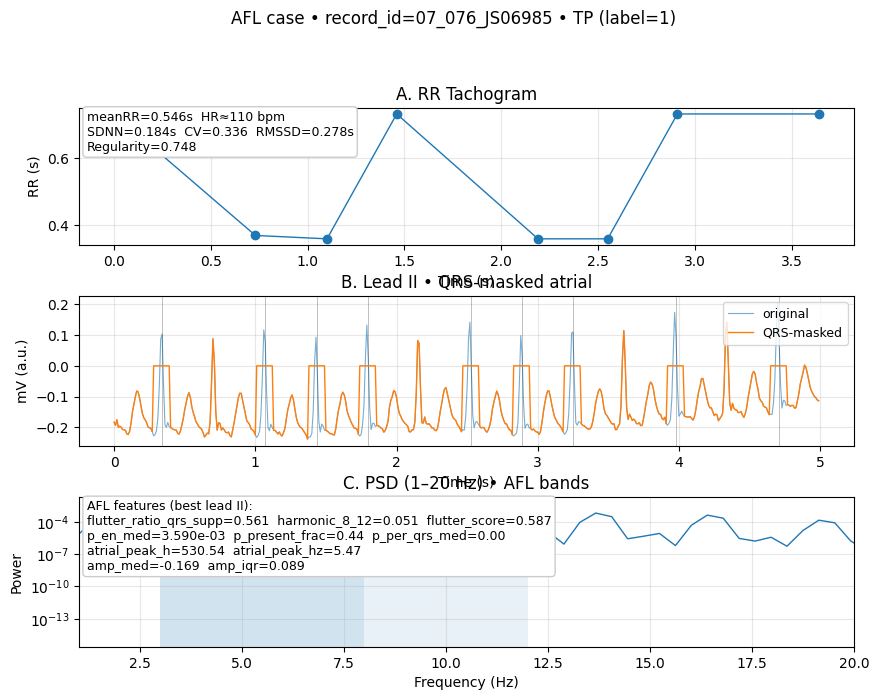

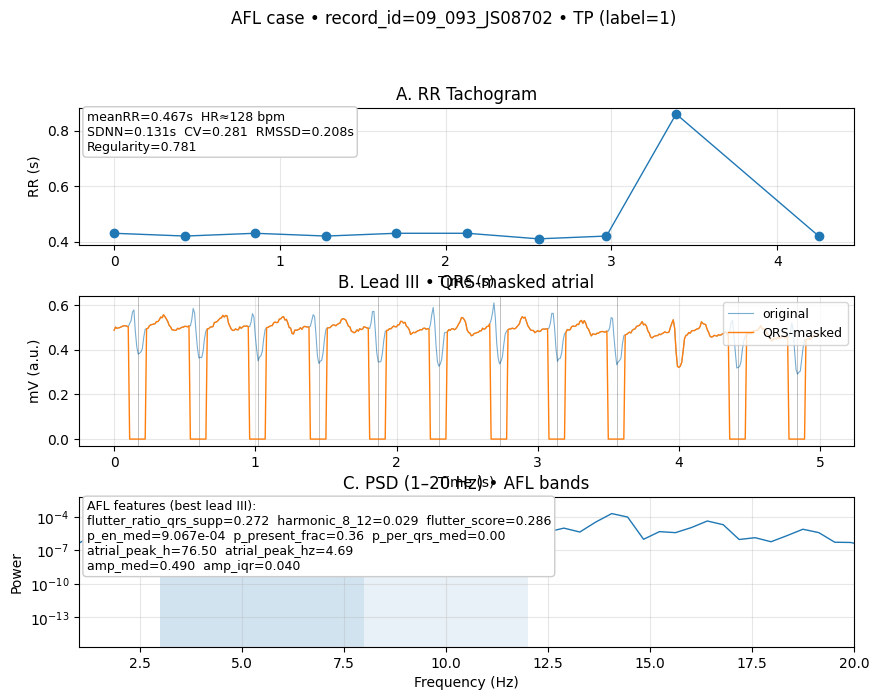

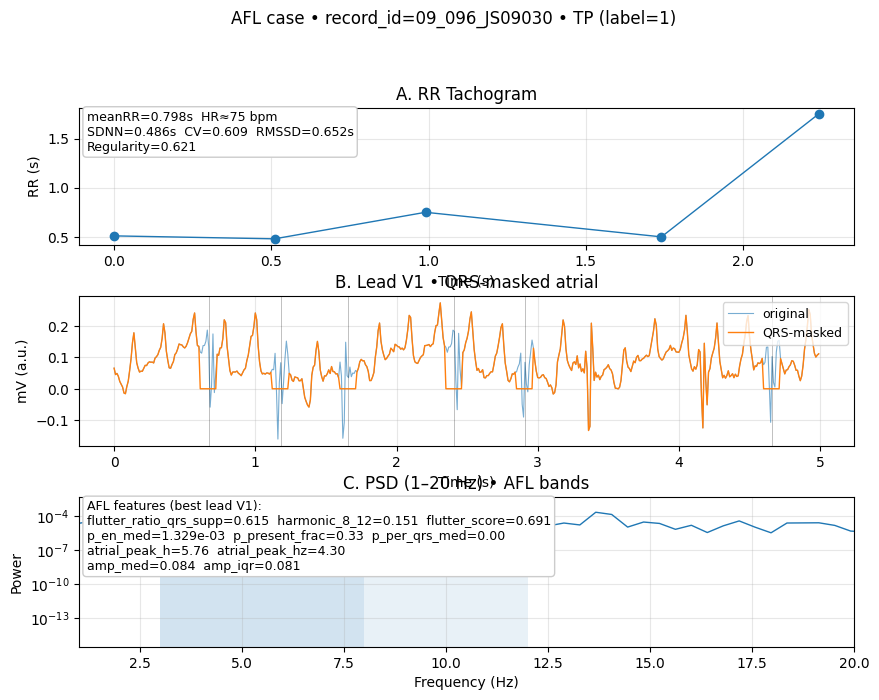

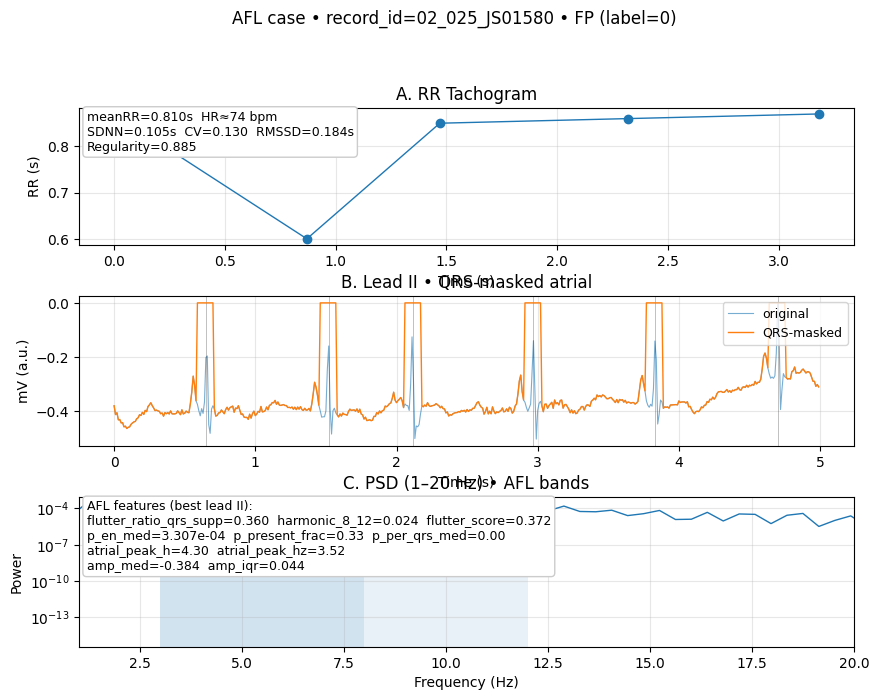

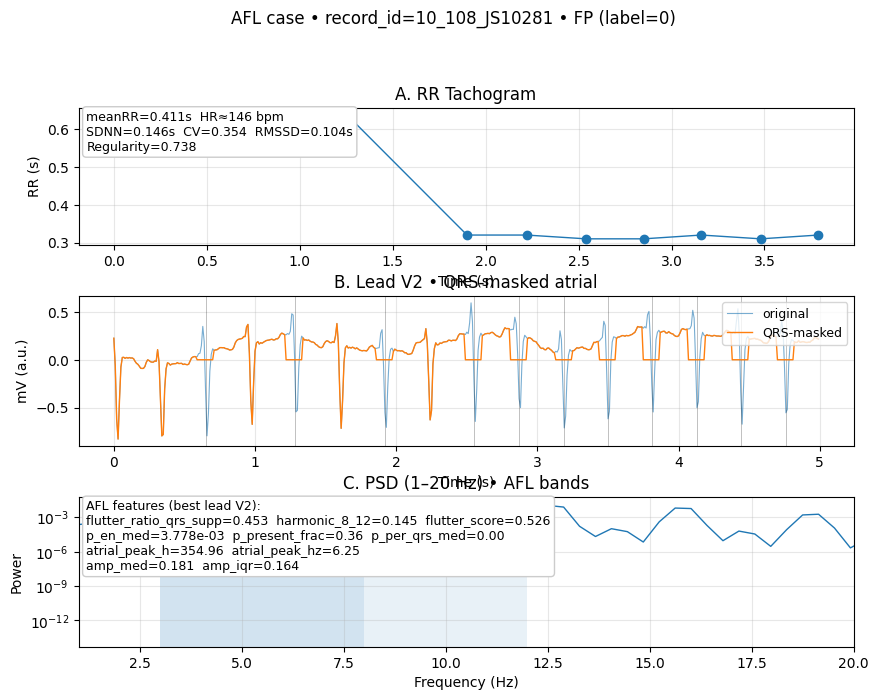

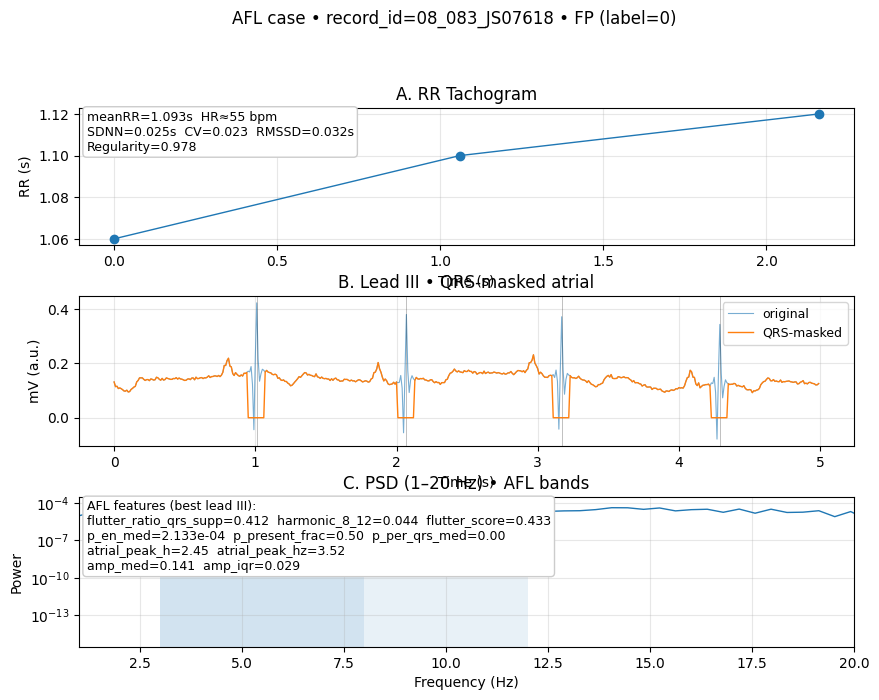

In [ ]:
# ===================== QUALITATIVE CASE PLOTS (AF & AFL) =====================
# - Plots RR intervals, QRS-masked atrial strip, PSD with shaded bands
# - Prints EXACT features used by your Stage-2 (AF or AFL)
# ---------------------------------------------------------------------------
# How to use:
# 1) Ensure your Stage-1 and Stage-2 ran (positives_<split>_with_labels.csv exists).
# 2) Set TASK and SPLIT below. Either set record_ids_tp/fp manually or keep None to auto-sample.
# 3) Run; figures appear for each record.

TASK  = "AFLvsREST"   # "AFvsREST" or "AFLvsREST"
SPLIT = "val"         # "val" or "test"

record_ids_tp = None  # e.g. ["06_060_JS05283", ...] or None to auto-sample
record_ids_fp = None  # e.g. ["06_999_ABC123", ...] or None to auto-sample

# ---------------------------- Imports & config ------------------------------
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, sosfiltfilt, welch, find_peaks

OUT = Path("/content/drive/MyDrive/HuBERT-ECG/processed_ptbxl_5s_100hz_fast")
FS = 100
LEADS = {'I':0,'II':1,'III':2,'aVR':3,'aVL':4,'aVF':5,'V1':6,'V2':7,'V3':8,'V4':9,'V5':10,'V6':11}

# ---------------------------- Signal helpers --------------------------------
def bandpass(sig, fs, lo, hi, order=4):
    ny = fs/2; hi = min(hi, ny*0.98)
    sos = butter(order, [lo/ny, hi/ny], btype='band', output='sos')
    return sosfiltfilt(sos, sig)

def safe_load_np(path):
    x = np.load(path)
    if x.ndim!=2 or x.shape[1]!=12:
        raise ValueError(f"bad shape {getattr(x,'shape',None)}")
    return x

def pick_lead_for_rhythm(x):
    for name in ['II','V1','V2']:
        idx = LEADS[name]
        if np.std(x[:,idx]) > 1e-4:
            return x[:,idx], name
    idx = np.argmax(np.std(x, axis=0))
    inv = {v:k for k,v in LEADS.items()}
    return x[:, idx], inv[idx]

def pick_lead_for_qrs(x):
    for name in ['II','V1','V2']:
        idx = LEADS[name]
        if np.std(x[:, idx]) > 1e-4:
            return x[:, idx], name
    idx = np.argmax(np.std(x, axis=0))
    inv = {v:k for k,v in LEADS.items()}
    return x[:, idx], inv[idx]

def detect_qrs(sig, fs=FS):
    y = bandpass(sig, fs, 5, 20)
    diff = np.diff(y, prepend=y[0]); sq = diff**2
    win = max(int(0.12*fs), 1)
    integ = np.convolve(sq, np.ones(win)/win, mode='same')
    peaks, _ = find_peaks(integ, distance=int(0.25*fs), prominence=np.percentile(integ, 85))
    return peaks

# ----------------------------- Feature blocks --------------------------------
# AF features (your Stage-2 AF extractor)
def rr_features(qrs_idx, fs=FS):
    if len(qrs_idx) < 3:
        return dict(rr_mean=np.nan, rr_std=np.nan, rr_cv=np.nan, rr_rmssd=np.nan, rr_reg=np.nan)
    rr = np.diff(qrs_idx)/fs
    mean = float(np.mean(rr)); std = float(np.std(rr))
    cv = float(std/(mean+1e-8))
    rmssd = float(np.sqrt(np.mean(np.diff(rr)**2))) if len(rr)>2 else np.nan
    reg = float(1.0/(1.0+cv))
    return dict(rr_mean=mean, rr_std=std, rr_cv=cv, rr_rmssd=rmssd, rr_reg=reg)

def pwave_metrics(sig, qrs_idx, fs=FS):
    if len(qrs_idx) < 2:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    bp = bandpass(sig, fs, 4, 15)
    wins = []
    for q in qrs_idx:
        a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.05*fs))
        if b > a:
            wins.append(bp[a:b])
    if not wins:
        return dict(p_en=np.nan, p_present=np.nan, p_to_qrs=np.nan)
    en = np.array([np.mean(w**2) for w in wins])
    p_en = float(np.median(en))
    thr = max(np.percentile(en, 60), 1e-6)
    p_present = float(np.mean(en > thr))
    pband = bandpass(sig, fs, 3, 9)
    p_peaks, _ = find_peaks(pband, distance=int(0.18*fs), prominence=np.percentile(np.abs(pband), 80))
    p_to_qrs = float(len(p_peaks)/(len(qrs_idx)+1e-6))
    return dict(p_en=p_en, p_present=p_present, p_to_qrs=p_to_qrs)

def flutter_bandpower(sig, fs=FS):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    mask_lo = (f>=3) & (f<=8)
    mask_all = (f>=1) & (f<=20)
    bp_3_8 = float(np.trapz(Pxx[mask_lo], f[mask_lo])) if mask_lo.any() else 0.0
    bp_1_20 = float(np.trapz(Pxx[mask_all], f[mask_all])) if mask_all.any() else 1e-12
    return dict(flutter_ratio = bp_3_8 / bp_1_20), (f, Pxx)

# AFL extras (your Stage-2 AFL extractor)
def bandpower_ratio(sig, fs, band, refband):
    f, Pxx = welch(bandpass(sig, fs, 1, 20), fs=fs, nperseg=min(256, len(sig)))
    m1 = (f>=band[0]) & (f<=band[1]); m2 = (f>=refband[0]) & (f<=refband[1])
    bp1 = float(np.trapz(Pxx[m1], f[m1])) if m1.any() else 0.0
    bp2 = float(np.trapz(Pxx[m2], f[m2])) if m2.any() else 1e-12
    return (bp1 / bp2), (f, Pxx)

def pwave_perbeat_metrics(sig, qrs_idx, fs=FS):
    if len(qrs_idx) < 2:
        return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
    pband = bandpass(sig, fs, 3, 9)
    en, p_perq = [], []
    for q in qrs_idx:
        a = max(0, q - int(0.20*fs)); b = max(0, q - int(0.06*fs))
        if b <= a: continue
        w = pband[a:b]
        en.append(np.mean(w**2))
        peaks, _ = find_peaks(w, distance=int(0.08*fs), prominence=np.percentile(np.abs(w), 80))
        p_perq.append(len(peaks))
    if not en: return dict(p_en_med=np.nan, p_present_frac=np.nan, p_per_qrs_med=np.nan)
    en = np.array(en)
    p_en_med = float(np.median(en))
    thr = max(np.percentile(en, 60), 1e-6)
    p_present_frac = float(np.mean(en > thr))
    p_per_qrs_med = float(np.median(p_perq)) if len(p_perq) else 0.0
    return dict(p_en_med=p_en_med, p_present_frac=p_present_frac, p_per_qrs_med=p_per_qrs_med)

# --------------------------- Plotting primitives -----------------------------
def plot_rr_panel(ax, qrs_idx):
    ax.set_title("A. RR Tachogram")
    if len(qrs_idx) < 2:
        ax.text(0.05,0.5,"<too few beats>", transform=ax.transAxes)
        return {}
    rr = np.diff(qrs_idx)/FS
    t = np.cumsum(np.r_[0, rr[:-1]])
    ax.plot(t, rr, marker='o', lw=1)
    stats = rr_features(qrs_idx)
    txt = (f"meanRR={stats['rr_mean']:.3f}s  HR≈{60.0/max(stats['rr_mean'],1e-6):.0f} bpm\n"
           f"SDNN={stats['rr_std']:.3f}s  CV={stats['rr_cv']:.3f}  RMSSD={stats['rr_rmssd']:.3f}s\n"
           f"Regularity={stats['rr_reg']:.3f}")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("RR (s)")
    ax.grid(True, alpha=0.3)
    ax.text(0.01, 0.98, txt, ha="left", va="top", transform=ax.transAxes,
            fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="0.8"))
    return stats

def qrs_mask_signal(sig, qrs_idx, width_ms=60):
    w = int(width_ms*FS/1000)
    sig2 = sig.copy()
    for q in qrs_idx:
        a = max(0, q - w); b = min(len(sig2), q + w)
        sig2[a:b] = 0.0
    return sig2

def plot_strip_panel_af(ax, sig, qrs_idx, lead_name="auto"):
    ax.set_title(f"B. Lead {lead_name} • QRS-masked atrial")
    t = np.arange(len(sig))/FS
    ax.plot(t, sig, lw=0.8, alpha=0.6, label="original")
    for q in qrs_idx:
        ax.axvline(q/FS, color='k', lw=0.7, alpha=0.25)
    masked = qrs_mask_signal(sig, qrs_idx, 60)
    ax.plot(t, masked, lw=1.0, label="QRS-masked")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("mV (a.u.)"); ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=9)
    return masked

def plot_psd_panel_af(ax, sig, title="C. PSD (1–20 Hz)"):
    ax.set_title(title)
    f, Pxx = welch(bandpass(sig, FS, 1, 20), fs=FS, nperseg=min(256, len(sig)))
    ax.semilogy(f, Pxx+1e-15, lw=1.0)
    # Shade 3–8 Hz
    ax.axvspan(3, 8, alpha=0.2, label="3–8 Hz")
    ax.axvspan(8, 12, alpha=0.1, label="8–12 Hz")
    ax.set_xlim(1, 20); ax.set_xlabel("Frequency (Hz)"); ax.set_ylabel("Power")
    ax.grid(True, alpha=0.3)
    return f, Pxx

# ----------------------- AF: full panel (features) ---------------------------
def plot_case_AF(record_id, out_path, label_text=""):
    x = safe_load_np(out_path)
    sig, lead_name = pick_lead_for_rhythm(x)
    qrs = detect_qrs(sig, FS)

    fig = plt.figure(figsize=(10, 7))
    gs = fig.add_gridspec(3, 1, height_ratios=[1.1, 1.2, 1.2], hspace=0.35)
    ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1]); ax3 = fig.add_subplot(gs[2])

    rr_stats = plot_rr_panel(ax1, qrs)
    masked = plot_strip_panel_af(ax2, sig, qrs, lead_name)

    # AF features & PSD
    flutter_dict, _ = flutter_bandpower(sig, FS)
    p_dict = pwave_metrics(sig, qrs, FS)
    f, Pxx = plot_psd_panel_af(ax3, sig)
    # overlay feature text
    feat_txt = (f"AF features:\n"
                f"rr_mean={rr_stats.get('rr_mean',np.nan):.3f}, rr_std={rr_stats.get('rr_std',np.nan):.3f}, "
                f"cv={rr_stats.get('rr_cv',np.nan):.3f}, rmssd={rr_stats.get('rr_rmssd',np.nan):.3f}, reg={rr_stats.get('rr_reg',np.nan):.3f}\n"
                f"p_en={p_dict['p_en']:.3e}, p_present={p_dict['p_present']:.2f}, p_to_qrs={p_dict['p_to_qrs']:.2f}\n"
                f"flutter_ratio(3–8 / 1–20)={flutter_dict['flutter_ratio']:.3f}")
    ax3.text(0.01, 0.98, feat_txt, ha="left", va="top", transform=ax3.transAxes,
             fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="0.8"))

    fig.suptitle(f"AF case • record_id={record_id} • {label_text}", y=1.02, fontsize=12)
    plt.show()

# ----------------------- AFL: full panel (features) --------------------------
def pick_best_afl_lead_and_scores(x, qrs):
    # Evaluate candidate leads with QRS suppression for flutter ratios / harmonics
    CANDIDATE_LEADS = ['V1','II','V2','III','aVF']
    best = None
    for name in CANDIDATE_LEADS:
        sig = x[:, LEADS[name]].astype(float).copy()
        if len(qrs) > 0:
            for q in qrs:
                a = max(0, q - int(0.06*FS)); b = min(len(sig), q + int(0.06*FS))
                sig[a:b] = 0.0
        fr, (f, Pxx) = bandpower_ratio(sig, FS, (3,8), (1,20))
        h2, _       = bandpower_ratio(sig, FS, (8,12), (1,20))
        score = fr + 0.5*h2
        item = (name, sig, fr, h2, score, f, Pxx)
        if (best is None) or (score > best[4]):
            best = item
    return best  # (name, sig, fr, h2, score, f, Pxx)

def plot_case_AFL(record_id, out_path, label_text=""):
    x = safe_load_np(out_path)
    qrs_lead, _ = pick_lead_for_qrs(x)
    qrs = detect_qrs(qrs_lead, FS)

    # pick best lead for atrial activity (with QRS suppression)
    best_name, best_sig_qs, fr, h2, score, f_best, Pxx_best = pick_best_afl_lead_and_scores(x, qrs)
    # Get raw (unmasked) best lead for plotting the strip
    best_sig_raw = x[:, LEADS[best_name]]

    # Compute P-wave per-beat metrics on the best lead (raw)
    pbeat = pwave_perbeat_metrics(best_sig_raw, qrs, FS)

    # Atrial peak height around 3.5–7 Hz
    f_psd, Pxx_psd = welch(bandpass(best_sig_raw, FS, 1, 20), fs=FS, nperseg=min(256,len(best_sig_raw)))
    mask = (f_psd>=3.5) & (f_psd<=7.0)
    if mask.any():
        i = np.argmax(Pxx_psd[mask]); f_peak = float(f_psd[mask][i]); pk = float(Pxx_psd[mask][i])
        lo = max(0, np.where(mask)[0][i]-5); hi = min(len(Pxx_psd), np.where(mask)[0][i]+6)
        baseline = 1e-12 + float(np.median(Pxx_psd[lo:hi])); atrial_peak_h = pk / baseline
    else:
        f_peak, atrial_peak_h = 0.0, 0.0

    fig = plt.figure(figsize=(10, 7))
    gs = fig.add_gridspec(3, 1, height_ratios=[1.1, 1.2, 1.2], hspace=0.35)
    ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1]); ax3 = fig.add_subplot(gs[2])

    rr_stats = plot_rr_panel(ax1, qrs)
    # Strip: show raw + QRS-masked on same best lead
    masked = plot_strip_panel_af(ax2, best_sig_raw, qrs, lead_name=best_name)

    # PSD on best lead (raw) for visibility; shade 3–8 and 8–12 bands
    ax3.set_title("C. PSD (1–20 Hz) • AFL bands")
    ax3.semilogy(f_psd, Pxx_psd+1e-15, lw=1.0)
    ax3.axvspan(3, 8, alpha=0.2, label="3–8 Hz")
    ax3.axvspan(8, 12, alpha=0.1, label="8–12 Hz")
    ax3.set_xlim(1, 20); ax3.set_xlabel("Frequency (Hz)"); ax3.set_ylabel("Power")
    ax3.grid(True, alpha=0.3)

    # AFL feature box (exact Stage-2 AFL features)
    feat_txt = (f"AFL features (best lead {best_name}):\n"
                f"flutter_ratio_qrs_supp={fr:.3f}  harmonic_8_12={h2:.3f}  flutter_score={score:.3f}\n"
                f"p_en_med={pbeat['p_en_med']:.3e}  p_present_frac={pbeat['p_present_frac']:.2f}  "
                f"p_per_qrs_med={pbeat['p_per_qrs_med']:.2f}\n"
                f"atrial_peak_h={atrial_peak_h:.2f}  atrial_peak_hz={f_peak:.2f}\n"
                f"amp_med={np.median(best_sig_raw):.3f}  amp_iqr={(np.percentile(best_sig_raw,75)-np.percentile(best_sig_raw,25)):.3f}")
    ax3.text(0.01, 0.98, feat_txt, ha="left", va="top", transform=ax3.transAxes,
             fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="0.8"))

    fig.suptitle(f"AFL case • record_id={record_id} • {label_text}", y=1.02, fontsize=12)
    plt.show()

# ------------------------- Driver: pick examples & plot -----------------------
# Load Stage-1 candidates with labels and paths
pos_wlab = OUT/f"stage1_{TASK}/positives_{SPLIT}_with_labels.csv"
assert Path(pos_wlab).exists(), f"Missing {pos_wlab}. Run Stage-1 first."
cand = pd.read_csv(pos_wlab)
cand["record_id"] = cand["record_id"].astype(str)
cand.rename(columns={"is_true_positive":"y"}, inplace=True)

split_df = pd.read_csv(OUT/f"split_{SPLIT}.csv").set_index("record_id")
split_df.index = split_df.index.astype(str)
cand["out_path"] = cand["record_id"].map(split_df["out_path"])
cand = cand.dropna(subset=["out_path"]).reset_index(drop=True)

# Auto-sample records if none provided
if record_ids_tp is None:
    record_ids_tp = cand.loc[cand["y"]==1, "record_id"].head(3).tolist()
if record_ids_fp is None:
    record_ids_fp = cand.loc[cand["y"]==0, "record_id"].head(3).tolist()

print(f"Plotting {len(record_ids_tp)} TP and {len(record_ids_fp)} FP examples for {TASK} ({SPLIT})")

def plot_one(record_id, y_val):
    row = cand[cand["record_id"]==record_id]
    if row.empty:
        print(f"  ! skip {record_id}: not in candidate pool")
        return
    path = row.iloc[0]["out_path"]
    lab = "TP (label=1)" if y_val==1 else "FP (label=0)"
    if TASK == "AFvsREST":
        plot_case_AF(record_id, path, label_text=lab)
    else:
        plot_case_AFL(record_id, path, label_text=lab)

for rid in record_ids_tp:
    plot_one(rid, 1)
for rid in record_ids_fp:
    plot_one(rid, 0)
# =================== END QUALITATIVE CASE PLOTS ===================


In [ ]:
# from the project root
!zip -r project.zip .
